# Origins of Volatility

# Table of Contents

* [Importing Libraries](#chapter1)
* [Importing Pluto Payments Data](#chapter2)
    * [Loading non-merged data](#section2_1)
    * [Loading merged data](#section2_2)
    * [Loading monthly-aggregated data](#section2_3)
    * [Clean Data](#section2_4)
    * [Aggregate Data by Month](#section2_5)
* [Distributions of sizes and growth rates](#chapter3)
    * [Distribution of sizes](#section3_1)
    * [Distribution of growth rates](#section3_2)
* [Degree Distribution](#chapter4)


# Import Libraries <a class="anchor" id="chapter2"></a>

In [2]:
import sys
import os

# Data Manipulation
import pandas as pd
import seaborn as sns
#import plotly.express as px
import pyreadr
import networkx as nx
from collections import Counter
from  itertools import combinations
import numpy as np

# Statistics
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import statsmodels.api as sm
import scipy.stats as stats
# We will use least_squares for our power-law fit
from scipy.optimize import least_squares
# To compute the skewness
from scipy.stats import skew


from matplotlib.patches import FancyBboxPatch

# Time-series analysis
    # Dick Fuller Test
from statsmodels.tsa.stattools import adfuller
    # Detrending time-series
from statsmodels.tsa.seasonal import seasonal_decompose
    # Convert to Datetie
from datetime import datetime
    # from pandas.plotting import autocorrelation_plot
from pandas.plotting import autocorrelation_plot
    # Auto-Correlation Computer
from statsmodels.tsa.stattools import acf
from datetime import datetime

#Scalers
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# Importing Pluto Data <a class="anchor" id="chapter2"></a>

## Cleaned Data

#### Loading data without assuming Education (85) is biased

In [3]:
subfolder = 'Saved_Data'
filename = 'Cleaned_Data_SIC5_no_edu.csv'
file_path = os.path.join(subfolder, filename)


dtype_mapping = {'from_pn': str, 'to_pn': str}

SIC5_clean_test_load = pd.read_csv(file_path,dtype=dtype_mapping)


In [4]:
result_SIC5_V3_amt = SIC5_clean_test_load.dropna()

Let us remove industries 0 and dormant companies 99999

In [5]:
result_SIC5_V3_amt = result_SIC5_V3_amt[(result_SIC5_V3_amt['from_pn'] !='0') & (result_SIC5_V3_amt['to_pn'] !='0')]
result_SIC5_V3_amt = result_SIC5_V3_amt[(result_SIC5_V3_amt['from_pn'] !='99999') & (result_SIC5_V3_amt['to_pn'] !='99999')]



## Computing the relevant time-series

### Cross-sectional firm size dispersion

Consider the lagged firm sizes, i.e. the sum of firm sizes of the previous year (or previous month)       and take the cross-sectional standard deviation, i.e. the standard deviation over all loged firm sizes of    that time-step  t.

We have already computed the monhtly aggregated output.

An important remark is that we are dealing with transaction data. Therefore output means that a company has been paid money. Hence, we need to groupby 'to' - industries.

- aggregate_output then corresponds to output of goods.
- aggregate_input then corresponds to input of goods.

In [549]:
aggregate_output_SIC5 = result_SIC5_V3_amt.drop(columns = 'to_pn').groupby(['from_pn']).sum().rename(columns = {'from_pn': 'output'})
aggregate_output_SIC5 = aggregate_output_SIC5[(aggregate_output_SIC5 != 0).all(axis=1)]




In [550]:
aggregate_input_SIC5 = result_SIC5_V3_amt.drop(columns = 'from_pn').groupby(['to_pn']).sum().rename(columns = {'to_pn': 'input'})
aggregate_input_SIC5 = aggregate_input_SIC5[(aggregate_input_SIC5 != 0).all(axis=1)]


In [8]:
common_indices = aggregate_input_SIC5.index.intersection(aggregate_output_SIC5.index)

# Filter both DataFrames to keep only the rows with common indices
aggregate_input_SIC5 = aggregate_input_SIC5.loc[common_indices]
aggregate_input_SIC5.index.name = 'to_pn'

Let us now compute the inshares and outshares for the entire dataset. This will be relevant for computing weighted in- and out-degrees.

In [9]:
int_df_in = pd.merge(pd.DataFrame(result_SIC5_V3_amt[['from_pn','to_pn']]).reset_index(),pd.DataFrame(result_SIC5_V3_amt.drop(columns =['from_pn','to_pn']).T.sum().reset_index()))
int_df_in = int_df_in.drop(columns =['index'])
int_df_in = int_df_in.set_index('to_pn')


int_df_out = pd.merge(pd.DataFrame(result_SIC5_V3_amt[['from_pn','to_pn']]).reset_index(),pd.DataFrame(result_SIC5_V3_amt.drop(columns =['from_pn','to_pn']).T.sum().reset_index()))
int_df_out = int_df_out.drop(columns =['index'])
int_df_out = int_df_out.set_index('from_pn')
                          
                          

In [10]:
inshares_full_df = pd.merge(int_df_in, pd.DataFrame(aggregate_input_SIC5.T.sum()), left_index=True, right_index=True, how='inner').reset_index()

outshares_full_df = pd.merge(int_df_out, pd.DataFrame(aggregate_output_SIC5.T.sum()), left_index=True, right_index=True, how='inner').reset_index()



In [11]:
inshares_full_df['inshare'] = inshares_full_df['0_x']/inshares_full_df['0_y']
outshares_full_df['outshare'] = outshares_full_df['0_x']/outshares_full_df['0_y']

We are now in a position to compute weighted in and out-degrees

In [12]:
weighted_indeg_df = outshares_full_df[['to_pn','outshare']].groupby('to_pn').sum().rename(columns = {'outshare': 'weight_indegree'})

In [13]:
weighted_outdeg_df = inshares_full_df[['from_pn','inshare']].groupby('from_pn').sum().rename(columns = {'inshare': 'weight_outdegree'})

In [14]:
total_production_SIC5 = aggregate_input_SIC5 + aggregate_output_SIC5

In [15]:
sectorial_GDP = 1/2*aggregate_output_SIC5

Let's compute the log of total sectorial sales.

Below we approximate the log by an arcsinh

In [16]:
intermediate_df = aggregate_output_SIC5.T.reset_index().rename(columns = {'index':'date'})

intermediate_df['date'] = intermediate_df['date'].str.replace('_amt_', '_')
intermediate_df['date'] = pd.to_datetime(intermediate_df['date'], format='%b_%y')
#cs_firm_size_dispersion_cut['DateColumn'] = cs_firm_size_dispersion_cut['DateColumn'].str.replace('_amt_', '_')  # Remove 'amt'
#cs_firm_size_dispersion_cut['DateColumn'] = pd.to_datetime(cs_firm_size_dispersion_cut['DateColumn'], format='%b_%y')  # Convert to datetime



In [17]:
intermediate_df_T = intermediate_df.T

In [18]:
intermediate_df_T.columns = intermediate_df_T.iloc[0]

/opt/homebrew/lib/python3.10/site-packages/pandas/core/indexes/base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)


In [19]:
intermediate_df_T = intermediate_df_T[1:]

In [20]:
aggregate_output_SIC5_date = intermediate_df_T.copy()

In [21]:
cs_firm_size_dispersion = np.log(aggregate_output_SIC5).std()

## Cross-sectional Average of Log firm growth

Let us compute the diff of logs

#### Aggregate growth rate

In [22]:
g_log_agg_season = np.log(aggregate_output_SIC5.sum()).T.diff(12).dropna().T

###### Seasonalized SIC-5 growth rates

In [23]:
col_seas_15 = ['jan_amt_15', 'feb_amt_15', 'mar_amt_15', 'apr_amt_15', 'may_amt_15',
       'jun_amt_15', 'jul_amt_15', 'aug_amt_15', 'sep_amt_15', 'oct_amt_15',
       'nov_amt_15', 'dec_amt_15']

col_seas_21 = ['aug_amt_21',
       'sep_amt_21', 'oct_amt_21', 'nov_amt_21', 'dec_amt_21', 'jan_amt_22',
       'feb_amt_22', 'mar_amt_22', 'apr_amt_22', 'may_amt_22', 'jun_amt_22',
       'jul_amt_22']

Note that double in the naming refers to the fact that we have used a "double arcsinh" transformation.

In [24]:
g_log_SIC5  = np.log(aggregate_output_SIC5).T.diff(12).dropna().T

In [25]:
g_log_SIC5_input  = np.log(aggregate_input_SIC5).T.diff(12).dropna().T

In [26]:
import pandas as pd

# Create or load your DataFrame (replace this with your own DataFrame)
data = {'Time': [1, 2, 3, 4],
        'Value1': [10, 15, 20, 25],
        'Value2': [12, 18, 24, 30],
        'Value3': [8, 12, 16, 20]}
df = pd.DataFrame(data)

# Define a custom function to calculate the difference and ratio
def calculate_diff_ratio(row):
    diffs = row.diff().dropna()  # Compute the difference, excluding the first column
    first_col_value = row.iloc[0]  # Get the value in the first column
    ratios = diffs / first_col_value  # Divide by the value in the first column
    return pd.Series(ratios.values, index=diffs.index)

# Apply the custom function row-wise to calculate differences and ratios
growth_rate_SIC5_Doyne = aggregate_output_SIC5.apply(calculate_diff_ratio, axis=1)




In [39]:

# Seasonalized Growth Rates

# Note that g_double_arcsinh_SIC5_seas starts in Jan-16 which corresponds to the 13th month in our data.
# For that reason in the second line below we assign 0 to 13.
# We taked [0:12] in the first line because we are interested in the std over a year.
cs_firm_growth_time_series_seas = pd.DataFrame(g_log_SIC5.T[0:12].std().T)
cs_firm_growth_time_series_seas = cs_firm_growth_time_series_seas.rename(columns = {0:12})




# The -1 is there because we could .diff() thus removing one column
for i in range(len(g_log_SIC5.T.diff())+1-13):
    #np.log(TFP_sigma).diff()[i+1:i+21].std()
    cs_firm_growth_time_series_seas[i + 13] = pd.DataFrame(g_log_SIC5.T[i+1:i+13].std().T)

In [40]:
cs_firm_growth_time_series_seas.columns = g_log_SIC5.T.iloc[:-11].T.columns

In [41]:
cs_firm_growth_time_series_seas.columns = pd.to_datetime(cs_firm_growth_time_series_seas.columns, format='%b_amt_%y')

###### Assigning A-posteriori Time-Steps

In [42]:

# Seasonalized Growth Rates

cs_firm_growth_time_series_ap_seas = pd.DataFrame(g_log_SIC5.T[0:13].std().T)
cs_firm_growth_time_series_ap_seas = cs_firm_growth_time_series_ap_seas.rename(columns = {0:12})




# The -1 is there because we could .diff() thus removing one column
for i in range(len(g_log_SIC5.T.diff())+1-13):
    #np.log(TFP_sigma).diff()[i+1:i+21].std()
    cs_firm_growth_time_series_ap_seas[i+13] = pd.DataFrame(g_log_SIC5.T[i+1:i+13].std().T)
    

In [43]:
cs_firm_growth_time_series_ap_seas.columns = g_log_SIC5.T.iloc[11:].T.columns

In [44]:
cs_firm_growth_time_series_ap_seas.columns = pd.to_datetime(cs_firm_growth_time_series_ap_seas.columns, format='%b_amt_%y')

###### Assigning Middle Time-Steps

In [45]:

# Seasonalized Growth Rates

cs_firm_growth_time_series_mid_seas = pd.DataFrame(g_log_SIC5.T[0:13].std().T)
cs_firm_growth_time_series_mid_seas = cs_firm_growth_time_series_mid_seas.rename(columns = {0:6})



# The -1 is there because we could .diff() thus removing one column
for i in range(len(g_log_SIC5.T.diff())+1-13):
    #np.log(TFP_sigma).diff()[i+1:i+21].std()
    
    cs_firm_growth_time_series_mid_seas[i+7] = pd.DataFrame(g_log_SIC5.T[i+1:i+13].std().T)
    

In [46]:
cs_firm_growth_time_series_mid_seas.columns = g_log_SIC5.T.iloc[5:-6].T.columns

In [47]:
cs_firm_growth_time_series_mid_seas.columns = pd.to_datetime(cs_firm_growth_time_series_mid_seas.columns, format='%b_amt_%y')

### Total Input + Output

Let us perform the same analysis as above but using input + output instead of just output.

In [55]:
total_production_SIC5 = aggregate_input_SIC5 + aggregate_output_SIC5

In [56]:
g_log_SIC5_total = np.log(total_production_SIC5).T.diff(12).dropna().T

In [57]:
cs_firm_size_dispersion_total_production = g_log_SIC5_total.std()

In [71]:

# Seasonalized Growth Rates

# Note that g_double_arcsinh_SIC5_seas starts in Jan-16 which corresponds to the 13th month in our data.
# For that reason in the second line below we assign 0 to 13.
# We taked [0:12] in the first line because we are interested in the std over a year.
cs_firm_growth_time_series_total_production = pd.DataFrame(g_log_SIC5_total.T[0:12].std().T)
cs_firm_growth_time_series_total_production = cs_firm_growth_time_series_total_production.rename(columns = {0:12})




# The -1 is there because we could .diff() thus removing one column
for i in range(len(g_log_SIC5_total.T.diff())+1-13):
    #np.log(TFP_sigma).diff()[i+1:i+21].std()
    cs_firm_growth_time_series_total_production[i + 13] = pd.DataFrame(g_log_SIC5_total.T[i+1:i+13].std().T)

In [72]:
cs_firm_growth_time_series_total_production.columns = g_log_SIC5_total.T.iloc[:-11].T.columns

In [73]:
cs_firm_growth_time_series_total_production.columns = pd.to_datetime(cs_firm_growth_time_series_total_production.columns, format='%b_amt_%y')

# Degree Distribution <a class="anchor" id="chapter4"></a>

Let us first determine the degree distribution without imposing any cut-off.

##### Aggregation by Year

In [58]:
cols_year_2015 = [c for c in result_SIC5_V3_amt.columns if c[8:10] == '15']
cols_year_2016 = [c for c in result_SIC5_V3_amt.columns if c[8:10] == '16']
cols_year_2017 = [c for c in result_SIC5_V3_amt.columns if c[8:10] == '17']
cols_year_2018 = [c for c in result_SIC5_V3_amt.columns if c[8:10] == '18']
cols_year_2019 = [c for c in result_SIC5_V3_amt.columns if c[8:10] == '19']
cols_year_2020 = [c for c in result_SIC5_V3_amt.columns if c[8:10] == '20']
cols_year_2021 = [c for c in result_SIC5_V3_amt.columns if c[8:10] == '21']

frames_2015 = [result_SIC5_V3_amt['from_pn'], result_SIC5_V3_amt['to_pn'], result_SIC5_V3_amt[cols_year_2015].sum(axis = 1)]

frames_2016 = [result_SIC5_V3_amt['from_pn'], result_SIC5_V3_amt['to_pn'], result_SIC5_V3_amt[cols_year_2016].sum(axis = 1)
]
frames_2017 = [result_SIC5_V3_amt['from_pn'], result_SIC5_V3_amt['to_pn'], result_SIC5_V3_amt[cols_year_2017].sum(axis = 1)
]
frames_2018 = [result_SIC5_V3_amt['from_pn'], result_SIC5_V3_amt['to_pn'], result_SIC5_V3_amt[cols_year_2018].sum(axis = 1)
]
frames_2019 = [result_SIC5_V3_amt['from_pn'], result_SIC5_V3_amt['to_pn'], result_SIC5_V3_amt[cols_year_2019].sum(axis = 1)
]
frames_2020 = [result_SIC5_V3_amt['from_pn'], result_SIC5_V3_amt['to_pn'], result_SIC5_V3_amt[cols_year_2020].sum(axis = 1)
]
frames_2021 = [result_SIC5_V3_amt['from_pn'], result_SIC5_V3_amt['to_pn'], result_SIC5_V3_amt[cols_year_2021].sum(axis = 1)
]

SIC5_2015 = pd.concat(frames_2015,axis = 1).rename(columns={0: "2015"})
SIC5_2016 = pd.concat(frames_2016,axis = 1).rename(columns={0: "2016"})
SIC5_2017 = pd.concat(frames_2017,axis = 1).rename(columns={0: "2017"})
SIC5_2018 = pd.concat(frames_2018,axis = 1).rename(columns={0: "2018"})
SIC5_2019 = pd.concat(frames_2019,axis = 1).rename(columns={0: "2019"})
SIC5_2020 = pd.concat(frames_2020,axis = 1).rename(columns={0: "2020"})
SIC5_2021 = pd.concat(frames_2021,axis = 1).rename(columns={0: "2021"})
SIC5_yearly = pd.concat([SIC5_2015, SIC5_2016.drop(columns = ['from_pn','to_pn']),SIC5_2017.drop(columns = ['from_pn','to_pn']),
                        SIC5_2018.drop(columns = ['from_pn','to_pn']),SIC5_2019.drop(columns = ['from_pn','to_pn']),SIC5_2020.drop(columns = ['from_pn','to_pn']),
                        SIC5_2021.drop(columns = ['from_pn','to_pn'])], axis=1)

## In-degree Distribution

In [59]:
# Keep in mind that we need to do some truncating

In [60]:
#SIC5_yearly[SIC5_yearly['to'] == '82999'].groupby('to').sum()

#SIC5_yearly.drop(columns = ['from']).groupby('to').sum()

SIC5_yearly['in_degree'] = SIC5_yearly['2016'].apply(lambda x: 1 if x > 0 else 0)
#SIC5_yearly[['to','in_degree']].groupby('to').sum().loc['82999']

In [61]:
indegree_2015 = SIC5_yearly[['to_pn','in_degree']].groupby('to_pn').sum()


In [62]:
SIC5_yearly['in_degree'] = SIC5_yearly['2015'].apply(lambda x: 1 if x > 0 else 0)
indegree_2015 = SIC5_yearly[['to_pn','in_degree']].groupby('to_pn').sum()

SIC5_yearly['in_degree'] = SIC5_yearly['2016'].apply(lambda x: 1 if x > 0 else 0)
indegree_2016 = SIC5_yearly[['to_pn','in_degree']].groupby('to_pn').sum()

SIC5_yearly['in_degree'] = SIC5_yearly['2017'].apply(lambda x: 1 if x > 0 else 0)
indegree_2017 = SIC5_yearly[['to_pn','in_degree']].groupby('to_pn').sum()

SIC5_yearly['in_degree'] = SIC5_yearly['2018'].apply(lambda x: 1 if x > 0 else 0)
indegree_2018 = SIC5_yearly[['to_pn','in_degree']].groupby('to_pn').sum()

SIC5_yearly['in_degree'] = SIC5_yearly['2019'].apply(lambda x: 1 if x > 0 else 0)
indegree_2019 = SIC5_yearly[['to_pn','in_degree']].groupby('to_pn').sum()


SIC5_yearly['in_degree'] = SIC5_yearly['2020'].apply(lambda x: 1 if x > 0 else 0)
indegree_2020 = SIC5_yearly[['to_pn','in_degree']].groupby('to_pn').sum()

SIC5_yearly['in_degree'] = SIC5_yearly['2021'].apply(lambda x: 1 if x > 0 else 0)
indegree_2021 = SIC5_yearly[['to_pn','in_degree']].groupby('to_pn').sum()

In [556]:
SIC5_agg['in_degree'] = SIC5_agg['transaction'].apply(lambda x: 1 if x > 0 else 0)
indegree_agg = SIC5_agg[['to_pn','in_degree']].groupby('to_pn').sum()

In [63]:
indegree_2015['rank'] = indegree_2015['in_degree'].rank(ascending=False).astype(int)
indegree_2016['rank'] = indegree_2016['in_degree'].rank(ascending=False).astype(int)
indegree_2017['rank'] = indegree_2017['in_degree'].rank(ascending=False).astype(int)
indegree_2018['rank'] = indegree_2018['in_degree'].rank(ascending=False).astype(int)
indegree_2019['rank'] = indegree_2019['in_degree'].rank(ascending=False).astype(int)
indegree_2020['rank'] = indegree_2020['in_degree'].rank(ascending=False).astype(int)
indegree_2021['rank'] = indegree_2021['in_degree'].rank(ascending=False).astype(int)

In [557]:
indegree_agg['rank'] = indegree_agg['in_degree'].rank(ascending=False).astype(int)

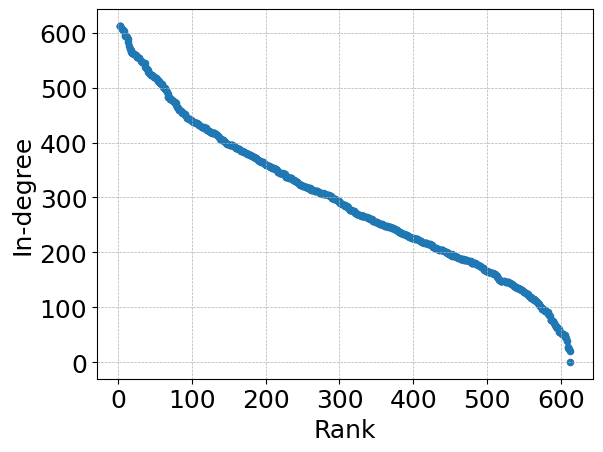

In [567]:
indegree_agg.sort_values(by='rank', ascending=True).plot(x='rank', y='in_degree',fontsize = 18, kind='scatter')
plt.xlabel('Rank', fontsize=18)
plt.ylabel('In-degree', fontsize=18)

plt.grid(True, which='both', linestyle='--', lw=0.5)


plt.savefig('plots/indegree_vs_rank_agg.png',bbox_inches='tight')
# show the plot
plt.show()


## Out-degree Distribution

In [65]:
# Keep in mind that we need to do some truncating

In [66]:
SIC5_yearly['in_degree'] = SIC5_yearly['2015'].apply(lambda x: 1 if x > 0 else 0)
outdegree_2015 = SIC5_yearly[['from_pn','in_degree']].groupby('from_pn').sum()


SIC5_yearly['in_degree'] = SIC5_yearly['2016'].apply(lambda x: 1 if x > 0 else 0)
outdegree_2016 = SIC5_yearly[['from_pn','in_degree']].groupby('from_pn').sum()

SIC5_yearly['in_degree'] = SIC5_yearly['2017'].apply(lambda x: 1 if x > 0 else 0)
outdegree_2017 = SIC5_yearly[['from_pn','in_degree']].groupby('from_pn').sum()

SIC5_yearly['in_degree'] = SIC5_yearly['2018'].apply(lambda x: 1 if x > 0 else 0)
outdegree_2018 = SIC5_yearly[['from_pn','in_degree']].groupby('from_pn').sum()

SIC5_yearly['in_degree'] = SIC5_yearly['2019'].apply(lambda x: 1 if x > 0 else 0)
outdegree_2019 = SIC5_yearly[['from_pn','in_degree']].groupby('from_pn').sum()


SIC5_yearly['in_degree'] = SIC5_yearly['2020'].apply(lambda x: 1 if x > 0 else 0)
outdegree_2020 = SIC5_yearly[['from_pn','in_degree']].groupby('from_pn').sum()

SIC5_yearly['in_degree'] = SIC5_yearly['2021'].apply(lambda x: 1 if x > 0 else 0)
outdegree_2021 = SIC5_yearly[['from_pn','in_degree']].groupby('from_pn').sum()

In [559]:
SIC5_agg['out_degree'] = SIC5_agg['transaction'].apply(lambda x: 1 if x > 0 else 0)
outdegree_agg = SIC5_agg[['from_pn','in_degree']].groupby('from_pn').sum()

In [67]:
outdegree_2015['rank'] = outdegree_2015['in_degree'].rank(ascending=False).astype(int)
outdegree_2016['rank'] = outdegree_2016['in_degree'].rank(ascending=False).astype(int)
outdegree_2017['rank'] = outdegree_2017['in_degree'].rank(ascending=False).astype(int)
outdegree_2018['rank'] = outdegree_2018['in_degree'].rank(ascending=False).astype(int)
outdegree_2019['rank'] = outdegree_2019['in_degree'].rank(ascending=False).astype(int)
outdegree_2020['rank'] = outdegree_2020['in_degree'].rank(ascending=False).astype(int)
outdegree_2021['rank'] = outdegree_2021['in_degree'].rank(ascending=False).astype(int)

In [560]:
outdegree_agg['rank'] = outdegree_agg['in_degree'].rank(ascending=False).astype(int)

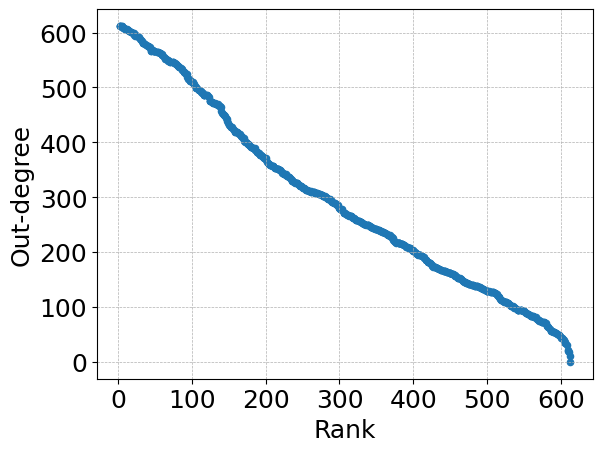

In [568]:
outdegree_agg.sort_values(by='rank', ascending=True).plot(x='rank', y='in_degree',fontsize = 18, kind='scatter')
plt.xlabel('Rank', fontsize=18)
plt.ylabel('Out-degree', fontsize=18)
#plt.title("2015",fontsize = 18)
#plt.savefig('plots/outdegree_vs_rank_2015.png',bbox_inches='tight')


plt.grid(True, which='both', linestyle='--', lw=0.5)

plt.savefig('plots/outdegree_vs_rank_agg.png',bbox_inches='tight')
# show the plot
plt.show()


# Raw Sample Volatility Computations - Preparation for regression

##### Average In-degree and Out-Degree

In [93]:
indegree_avg = pd.DataFrame(indegree_2015['in_degree'] + indegree_2016['in_degree'] + indegree_2017['in_degree'] + indegree_2018['in_degree']
+ indegree_2019['in_degree'] + indegree_2020['in_degree'] + indegree_2021['in_degree'])/7


In [94]:
outdegree_avg = pd.DataFrame(outdegree_2015['in_degree'] + outdegree_2016['in_degree'] + outdegree_2017['in_degree'] + outdegree_2018['in_degree']
+ outdegree_2019['in_degree'] + outdegree_2020['in_degree'] + outdegree_2021['in_degree'])/7


In [95]:
outdegree_avg = outdegree_avg.rename(columns={'in_degree': 'out_degree'})

In [96]:
df_vol_sample = pd.DataFrame(g_log_SIC5.T.std()).rename(columns={0: 'Volatility'})
df_vol_seas_sample = pd.DataFrame(g_log_SIC5.T.std()).rename(columns={0: 'Volatility(seas)'})





In [97]:

df_vol_degree = df_vol_seas_sample.merge(indegree_avg, left_index=True, right_index=True)
df_vol_degree = df_vol_degree.merge(outdegree_avg, left_index=True, right_index=True)


In [574]:
df_vol_degree['Volatility_costs'] = pd.DataFrame(g_log_SIC5_input.T.std())[0]

In [576]:
df_vol_degree['log_Volatility_costs'] = np.log(df_vol_degree['Volatility_costs'])

In [98]:
df_vol_degree['in_degree_bins'] = pd.cut(df_vol_degree['in_degree'], bins=50)  # You can specify the number of bins here
df_vol_degree['out_degree_bins'] = pd.cut(df_vol_degree['out_degree'], bins=50)  # You can specify the number of bins here




##### Katz-Bonacich centrality (Acemoglu - Costs)

In [99]:
result_SIC5_V3_amt_non_zero = result_SIC5_V3_amt[(result_SIC5_V3_amt != 0).all(axis=1)]

In [100]:
agg_transaction = pd.DataFrame(result_SIC5_V3_amt.drop(columns = ['from_pn','to_pn']).sum(axis = 1))

In [101]:
agg_transaction['from_pn'] = result_SIC5_V3_amt['from_pn']
agg_transaction['to_pn'] = result_SIC5_V3_amt['to_pn']

In [102]:
agg_transaction_non_zero = agg_transaction[(agg_transaction != 0).all(axis=1)]

In [103]:
nodelist_harm = agg_transaction_non_zero['to_pn'].unique()

Z_ij_pluto = []
for col in agg_transaction_non_zero.drop(columns = ['from_pn','to_pn']).columns:
    G_pluto_harm = nx.from_pandas_edgelist(agg_transaction_non_zero,'from_pn','to_pn',col,create_using=nx.DiGraph())
    Adjtraining_pluto_harm = nx.adjacency_matrix(G_pluto_harm, nodelist = nodelist_harm,weight=col)
    Z_ij_pluto.append(Adjtraining_pluto_harm.todense())


/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/977537721.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Adjtraining_pluto_harm = nx.adjacency_matrix(G_pluto_harm, nodelist = nodelist_harm,weight=col)


In [104]:
Bonacich_centrality_agg = []

for i in range(len(Z_ij_pluto)):
    col_sum_zij_pluto = np.sum(Z_ij_pluto[i],axis = 0)

##### Note that here we are computing the transpose of W (the input shares matrix)
    X_ij_pluto = Z_ij_pluto[i].dot(np.diag(1/np.ravel(col_sum_zij_pluto)))
    
    alpha = 0.5
    lamb = alpha
    eta = (1-alpha)/len(X_ij_pluto)


    Bonacich_centrality_agg.append((eta*(np.linalg.inv(np.eye(len(X_ij_pluto))-lamb*X_ij_pluto))).dot(np.ones((len(X_ij_pluto),1))))



In [105]:
Bonacich_centrality_agg_df = pd.DataFrame(np.squeeze(Bonacich_centrality_agg)).rename(columns = {0: 'centrality'})

In [106]:
Bonacich_centrality_agg_df.index = agg_transaction_non_zero['to_pn'].unique()

In [107]:
common_indices = Bonacich_centrality_agg_df.index.intersection(df_vol_degree.index)

# Filter both DataFrames to keep only the rows with common indices
Bonacich_centrality_agg_df = Bonacich_centrality_agg_df.loc[common_indices]


In [108]:
df_vol_degree['centrality'] = Bonacich_centrality_agg_df['centrality']

In [109]:
df_vol_degree['log_centrality'] = np.log(df_vol_degree['centrality'])

##### Katz-Bonacich centrality (Acemoglu - Sales)

In [99]:
result_SIC5_V3_amt_non_zero = result_SIC5_V3_amt[(result_SIC5_V3_amt != 0).all(axis=1)]

In [100]:
agg_transaction = pd.DataFrame(result_SIC5_V3_amt.drop(columns = ['from_pn','to_pn']).sum(axis = 1))

In [101]:
agg_transaction['from_pn'] = result_SIC5_V3_amt['from_pn']
agg_transaction['to_pn'] = result_SIC5_V3_amt['to_pn']

In [102]:
agg_transaction_non_zero = agg_transaction[(agg_transaction != 0).all(axis=1)]

In [325]:
nodelist_harm = agg_transaction_non_zero['from_pn'].unique()

Z_ij_pluto = []
for col in agg_transaction_non_zero.drop(columns = ['from_pn','to_pn']).columns:
    G_pluto_harm = nx.from_pandas_edgelist(agg_transaction_non_zero,'from_pn','to_pn',col,create_using=nx.DiGraph())
    Adjtraining_pluto_harm = nx.adjacency_matrix(G_pluto_harm, nodelist = nodelist_harm,weight=col)
    Z_ij_pluto.append(Adjtraining_pluto_harm.todense())


/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/4184902158.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Adjtraining_pluto_harm = nx.adjacency_matrix(G_pluto_harm, nodelist = nodelist_harm,weight=col)


In [330]:
Bonacich_centrality_agg = []

for i in range(len(Z_ij_pluto)):
    row_sum_zij_pluto = np.sum(Z_ij_pluto[i],axis = 1)

##### Note that here we are computing the transpose of W (the input shares matrix)
    X_ij_pluto = Z_ij_pluto[i].dot(np.diag(1/np.ravel(row_sum_zij_pluto)))
    
    alpha = 0.5
    lamb = alpha
    eta = (1-alpha)/len(X_ij_pluto)


    Bonacich_centrality_agg.append((eta*(np.linalg.inv(np.eye(len(X_ij_pluto))-lamb*X_ij_pluto))).dot(np.ones((len(X_ij_pluto),1))))



In [331]:
Bonacich_centrality_sales_df = pd.DataFrame(np.squeeze(Bonacich_centrality_agg)).rename(columns = {0: 'centrality'})

In [332]:
Bonacich_centrality_sales_df.index = agg_transaction_non_zero['from_pn'].unique()

In [333]:
common_indices = Bonacich_centrality_sales_df.index.intersection(df_vol_degree.index)

# Filter both DataFrames to keep only the rows with common indices
Bonacich_centrality_sales_df = Bonacich_centrality_sales_df.loc[common_indices]


In [334]:
df_vol_degree['centrality_sales'] = Bonacich_centrality_sales_df['centrality']

In [335]:
df_vol_degree['log_centrality_sales'] = np.log(df_vol_degree['centrality_sales'])

#### Sales and Costs

In [110]:
df_vol_degree['sales'] = aggregate_output_SIC5.T.mean()

In [111]:
df_vol_degree['log_sales'] = np.log(aggregate_output_SIC5.T.mean())

In [112]:
common_indices = aggregate_input_SIC5.index.intersection(aggregate_output_SIC5.index)

# Filter both DataFrames to keep only the rows with common indices
aggregate_input_SIC5 = aggregate_input_SIC5.loc[common_indices]

In [113]:
df_vol_degree['costs'] = aggregate_input_SIC5.T.mean()

In [114]:
df_vol_degree['log_costs'] = np.log(aggregate_input_SIC5.T.mean())

###### Log-Log Plot Volatility of Growth Rates vs Out-degree

<Figure size 800x600 with 0 Axes>

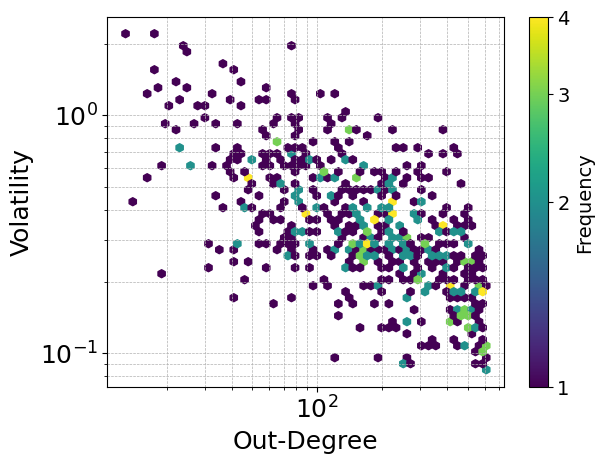

In [116]:
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(8, 6))
fig = plt.figure()
ax = plt.gca()


hb = plt.hexbin(df_vol_degree['out_degree'],df_vol_degree['Volatility(seas)'] , gridsize=50,bins='log', xscale='log', yscale='log')

#ax.scatter(df_vol_degree['out_degree'],df_vol_degree['Volatility(seas)'] , c='blue', alpha=0.5, edgecolors='none')
#ax.set_yscale('log')
#ax.set_xscale('log')
# Customize the plot



plt.xlabel("Out-Degree",fontsize=18)
plt.ylabel(r'Volatility',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# Add a colorbar

# Get the current colorbar
#cbar = plt.colorbar()

# Add a colorbar
cbar = plt.colorbar(hb, format=ScalarFormatter())  # Use ScalarFormatter to control the format

# Define the specific tick locations and labels you want
custom_ticks = [1, 2, 3, 4]
custom_labels = ['1', '2', '3', '4']

# Set the colorbar ticks and labels
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels(custom_labels)
cbar.ax.yaxis.set_tick_params(labelsize=14)  # Adjust the fontsize (change 14 to your desired size)
cbar.set_label('Frequency', fontsize=14)  # Adjust the label text and fontsize as needed


plt.grid(True, which='both', linestyle='--', lw=0.5)
#plt.legend()

#plt.savefig('plots/mean_volatility_sample_vs_outdegree_Hexbin.pdf',bbox_inches='tight')


plt.show()


<Figure size 800x600 with 0 Axes>

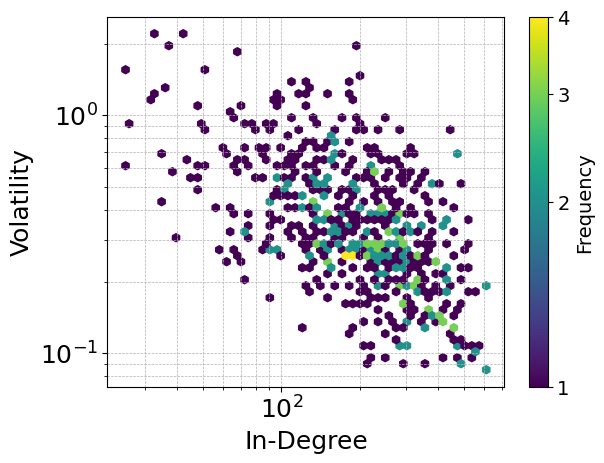

In [117]:
plt.figure(figsize=(8, 6))
fig = plt.figure()
ax = plt.gca()


hb = plt.hexbin(df_vol_degree['in_degree'],df_vol_degree['Volatility(seas)'] , gridsize=50,bins='log', xscale='log', yscale='log')

#ax.scatter(df_vol_degree['out_degree'],df_vol_degree['Volatility(seas)'] , c='blue', alpha=0.5, edgecolors='none')
#ax.set_yscale('log')
#ax.set_xscale('log')
# Customize the plot



plt.xlabel("In-Degree",fontsize=18)
plt.ylabel(r'Volatility',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# Add a colorbar
# Add a colorbar
cbar = plt.colorbar(hb, format=ScalarFormatter())  # Use ScalarFormatter to control the format

# Define the specific tick locations and labels you want
custom_ticks = [1, 2, 3, 4]
custom_labels = ['1', '2', '3', '4']

# Set the colorbar ticks and labels
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels(custom_labels)
cbar.ax.yaxis.set_tick_params(labelsize=14)  # Adjust the fontsize (change 14 to your desired size)

cbar.set_label('Frequency', fontsize=14)  # Adjust the label text and fontsize as needed

#
plt.grid(True, which='both', linestyle='--', lw=0.5)
#plt.legend()

#plt.savefig('plots/mean_volatility_sample_vs_indegree_Hexbin.pdf',bbox_inches='tight')


plt.show()

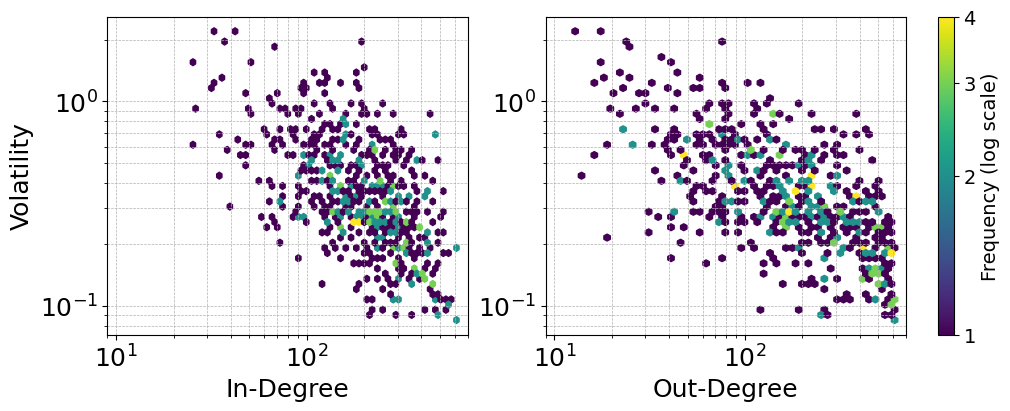

In [121]:
import matplotlib.pyplot as plt
import numpy as np

# Generate example data for hexbin plots
x1 = np.random.randn(1000)
y1 = np.random.randn(1000)
x2 = np.random.randn(1000) + 1
y2 = np.random.randn(1000)

# Create a 1x2 grid with constrained layout
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Create the first hexbin plot
hb1 = axs[0].hexbin(df_vol_degree['in_degree'],df_vol_degree['Volatility(seas)'] , gridsize=50,bins='log', xscale='log', yscale='log')



#axs[0].set_title('Hexbin Plot 1')
axs[0].set_xlabel("In-Degree",fontsize=18)
axs[0].set_ylabel(r'Volatility',fontsize=18)
axs[0].grid(True, which='both', linestyle='--', lw=0.5)



# Create the second hexbin plot
hb2 = axs[1].hexbin(df_vol_degree['out_degree'],df_vol_degree['Volatility(seas)'] , gridsize=50,bins='log', xscale='log', yscale='log')


#axs[1].set_title('Hexbin Plot 2')
axs[1].set_xlabel("Out-Degree",fontsize=18)
#axs[1].set_ylabel(r'Volatility',fontsize=18)
axs[1].grid(True, which='both', linestyle='--', lw=0.5)


# Create a colorbar shared between both plots
cbar = plt.colorbar(hb2, ax=axs, fraction=0.03, pad=0.04)
cbar.set_label('Frequency (log scale)',fontsize=14)

# Define the specific tick locations and labels you want
custom_ticks = [1, 2, 3, 4]
custom_labels = ['1', '2', '3', '4']

# Set the colorbar ticks and labels
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels(custom_labels)
cbar.ax.yaxis.set_tick_params(labelsize=14)  # Adjust the fontsize (change 14 to your desired size)



tick_size = 18  # Set your desired tick size


for ax in axs:
    ax.tick_params(axis='both', which='both', labelsize=tick_size)
    #ax.tick_params(axis='both', which='both', length=2, width=2)

# Set the same x-range for both subplots
common_xlim = (0.9*10**1, 7*10**2)  # Set your desired x-range
for ax in axs:
    ax.set_xlim(common_xlim)


#plt.suptitle('Side-by-Side Hexbin Plots with Shared Colorbar')
#plt.savefig('plots/mean_volatility_sample_vs_degree_Hexbin.png',bbox_inches='tight')
plt.show()


One important remark for below:

`np.digitize` is a NumPy function used to bin a continuous variable into discrete intervals or bins. It's a way to transform a continuous variable into a categorical one based on specified bin edges. Here's how `np.digitize(df_vol_degree['in_degree'], log_bins)` works in your context:

- `df_vol_degree['in_degree']` is a pandas Series that represents the 'in_degree' values from your DataFrame.
- `log_bins` is an array of bin edges that you've predefined. These bin edges are the boundaries that you'll use to categorize your 'in_degree' data.

The `np.digitize` function takes the values from `df_vol_degree['in_degree']` and assigns each value to the bin it falls into, based on the specified `log_bins`. The result is a new array or Series where each value represents the bin number to which the corresponding 'in_degree' value belongs.

For example, if you have 'in_degree' values like [2, 10, 15, 30] and your `log_bins` are [1, 5, 10, 20], `np.digitize` will return an array like [1, 3, 3, 4]. This means that 2 is in the first bin (between 1 and 5), 10 and 15 are in the third bin (between 10 and 20), and 30 is in the fourth bin (greater than 20).

This is a useful technique when you want to categorize or group continuous data into specific intervals or bins for further analysis or visualization. It's common in histograms or when you need to create discrete categories from continuous data.

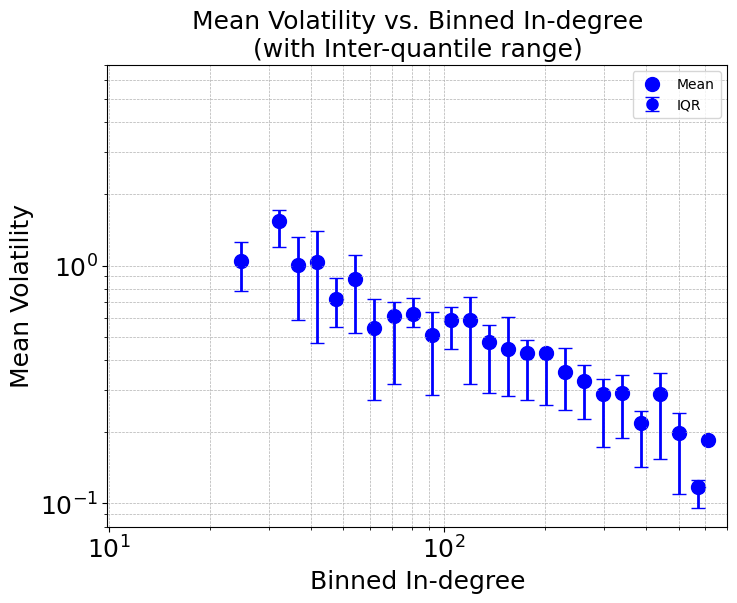

In [124]:


#df_vol_degree['in_degree'],df_vol_degree['Volatility(seas)']

# Define the number of logarithmic bins
num_bins = 50  # Change this to 3

# Create logarithmic bins using numpy
log_bins = np.logspace(0, np.log10(df_vol_degree['in_degree'].max()), num_bins)
df_vol_degree['in_degree_Log_Bin'] = np.digitize(df_vol_degree['in_degree'], log_bins)

# Group by the 'X_Log_Bin' and calculate mean and quantiles of 'Y'
result = df_vol_degree.groupby('in_degree_Log_Bin')['Volatility(seas)'].agg(['mean', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])

# Create a log-log scatter plot
plt.figure(figsize=(8, 6))
x = [np.mean(log_bins[i - 1:i + 1]) for i in result.index]  # Convert bin edges to bin centers
plt.scatter(x, result['mean'], label='Mean', color='blue', marker='o', s=100)
plt.errorbar(x, result['mean'], yerr=[np.abs(result['<lambda_0>'] - result['mean']) , np.abs(result['<lambda_1>'] - result['mean'])],
             fmt='o', color='blue', markersize=8, capsize=5, label='IQR', elinewidth=2)

# Customize the plot
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.08, 7)  # Specify the y-axis limits in log space
plt.xlim(3, 700)  # Specify the x-axis limits in log space

plt.xlabel('Binned In-degree',fontsize = 18)
plt.ylabel('Mean Volatility',fontsize = 18)
plt.title('Mean Volatility vs. Binned In-degree\n(with Inter-quantile range)',fontsize = 18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, which='both', linestyle='--', lw=0.5)
plt.legend()
plt.xlim((0.99*10**1, 7*10**2))

#plt.savefig('plots/mean_volatility_sample_vs_indegree_LogLog.pdf',bbox_inches='tight')
plt.show()


In [126]:
df_vol_degree['log_in_degree'] = np.log(df_vol_degree['in_degree'])
df_vol_degree['log_out_degree'] = np.log(df_vol_degree['out_degree'])
df_vol_degree['log_Volatility_seas'] = np.log(df_vol_degree['Volatility(seas)'])

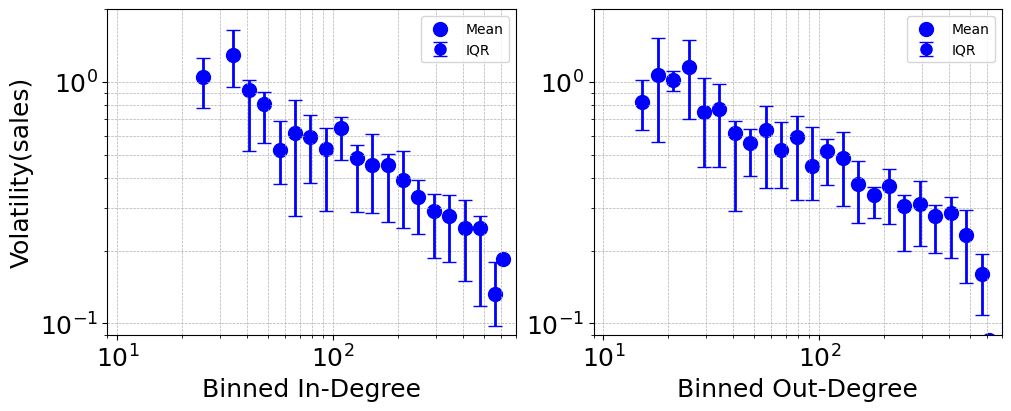

In [734]:
# Create a 1x2 grid with constrained layout
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Create the first hexbin plot
#hb1 = axs[0].hexbin(df_vol_degree['in_degree'],df_vol_degree['Volatility(seas)'] , gridsize=50,bins='log', xscale='log', yscale='log')




#axs[0].set_title('Hexbin Plot 1')
axs[0].set_xlabel("Binned In-Degree",fontsize=18)
axs[0].set_ylabel(r'Volatility(sales)',fontsize=18)
axs[0].grid(True, which='both', linestyle='--', lw=0.5)



# Define the number of logarithmic bins
num_bins = 40  # Change this to 3

# Create logarithmic bins using numpy
log_bins = np.logspace(0, np.log10(df_vol_degree['in_degree'].max()), num_bins)
df_vol_degree['in_degree_Log_Bin'] = np.digitize(df_vol_degree['in_degree'], log_bins)

# Group by the 'X_Log_Bin' and calculate mean and quantiles of 'Y'
result = df_vol_degree.groupby('in_degree_Log_Bin')['Volatility(seas)'].agg(['mean', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])

# Create a log-log scatter plot
x = [np.mean(log_bins[i - 1:i + 1]) for i in result.index]  # Convert bin edges to bin centers
axs[0].scatter(x, result['mean'], label='Mean', color='blue', marker='o', s=100)
axs[0].errorbar(x, result['mean'], yerr=[np.abs(result['<lambda_0>'] - result['mean']) , np.abs(result['<lambda_1>'] - result['mean'])],
             fmt='o', color='blue', markersize=8, capsize=5, label='IQR', elinewidth=2)

# Customize the plot
axs[0].set_xscale('log')
axs[0].set_yscale('log')
#plt.ylim(0.08, 7)  # Specify the y-axis limits in log space
#plt.xlim(3, 700)  # Specify the x-axis limits in log space


#axs[0].set_title('Hexbin Plot 1')
axs[1].set_xlabel("Binned Out-Degree",fontsize=18)
#axs[1].set_ylabel(r'Mean Volatility',fontsize=18)
axs[1].grid(True, which='both', linestyle='--', lw=0.5)



# Define the number of logarithmic bins
num_bins = 40  # Change this to 3

# Create logarithmic bins using numpy
log_bins = np.logspace(0, np.log10(df_vol_degree['out_degree'].max()), num_bins)
df_vol_degree['out_degree_Log_Bin'] = np.digitize(df_vol_degree['out_degree'], log_bins)

# Group by the 'X_Log_Bin' and calculate mean and quantiles of 'Y'
result = df_vol_degree.groupby('out_degree_Log_Bin')['Volatility(seas)'].agg(['mean', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])

# Create a log-log scatter plot
x = [np.mean(log_bins[i - 1:i + 1]) for i in result.index]  # Convert bin edges to bin centers
axs[1].scatter(x, result['mean'], label='Mean', color='blue', marker='o', s=100)
axs[1].errorbar(x, result['mean'], yerr=[np.abs(result['<lambda_0>'] - result['mean']) , np.abs(result['<lambda_1>'] - result['mean'])],
             fmt='o', color='blue', markersize=8, capsize=5, label='IQR', elinewidth=2)

# Customize the plot
axs[1].set_xscale('log')
axs[1].set_yscale('log')

#axs[0].legend()
axs[1].legend()
axs[0].legend()

#axs[0].text(102, 0.9, 'Slope = -0.46', fontsize=14, color='black')
#axs[1].text(102, 1.1, 'Slope = -0.58', fontsize=14, color='black')



tick_size = 18  # Set your desired tick size


for ax in axs:
    ax.tick_params(axis='both', which='both', labelsize=tick_size)
    #ax.tick_params(axis='both', which='both', length=2, width=2)

# Set the same x-range for both subplots
common_xlim = (9*10**0, 7*10**2)  # Set your desired x-range
for ax in axs:
    ax.set_xlim(common_xlim)

    
# Set the same x-range for both subplots
common_ylim = (0.9*10**-1, 2*10**0)  # Set your desired x-range
for ax in axs:
    ax.set_ylim(common_ylim)

plt.savefig('plots/mean_volatility_sample_vs_degree_binned.png',bbox_inches='tight')

plt.show()

## Computing the Herfindahl Index

###### Preparation to compute the Herfindahl

In [129]:
SIC5_agg = pd.DataFrame(SIC5_yearly.drop(columns = ['from_pn','to_pn','in_degree']).sum(axis = 1)).rename(columns = {0:'transaction'})

In [130]:
SIC5_agg['to_pn'] = SIC5_yearly['to_pn']
SIC5_agg['from_pn'] = SIC5_yearly['from_pn']


In [131]:
Z_agg_rel_in = pd.merge(SIC5_agg[['to_pn','transaction']],SIC5_agg.groupby('to_pn')['transaction'].agg('sum'),on="to_pn")

Z_agg_rel_in = Z_agg_rel_in.rename(columns={"transaction_x": "Transaction", "transaction_y": "Industry_Input"})

Z_agg_rel_in['Share'] = Z_agg_rel_in['Transaction']/Z_agg_rel_in['Industry_Input']
Z_agg_rel_in.loc[:, 'Share^2'] =  Z_agg_rel_in['Share']**2






In [132]:
Z_agg_rel = pd.merge(SIC5_agg[['from_pn','transaction']],SIC5_agg.groupby('from_pn')['transaction'].agg('sum'),on="from_pn")

Z_agg_rel = Z_agg_rel.rename(columns={"transaction_x": "Transaction", "transaction_y": "Industry_Output"})

Z_agg_rel['Share'] = Z_agg_rel['Transaction']/Z_agg_rel['Industry_Output']
Z_agg_rel.loc[:, 'Share^2'] =  Z_agg_rel['Share']**2


In [133]:
Z_2015_rel_in = pd.merge(SIC5_yearly[['to_pn','2015']],SIC5_yearly.groupby('to_pn')['2015'].agg('sum'),on="to_pn")
Z_2016_rel_in = pd.merge(SIC5_yearly[['to_pn','2016']],SIC5_yearly.groupby('to_pn')['2016'].agg('sum'),on="to_pn")
Z_2017_rel_in = pd.merge(SIC5_yearly[['to_pn','2017']],SIC5_yearly.groupby('to_pn')['2017'].agg('sum'),on="to_pn")
Z_2018_rel_in = pd.merge(SIC5_yearly[['to_pn','2018']],SIC5_yearly.groupby('to_pn')['2018'].agg('sum'),on="to_pn")
Z_2019_rel_in = pd.merge(SIC5_yearly[['to_pn','2019']],SIC5_yearly.groupby('to_pn')['2019'].agg('sum'),on="to_pn")
Z_2020_rel_in = pd.merge(SIC5_yearly[['to_pn','2020']],SIC5_yearly.groupby('to_pn')['2020'].agg('sum'),on="to_pn")
Z_2021_rel_in = pd.merge(SIC5_yearly[['to_pn','2021']],SIC5_yearly.groupby('to_pn')['2021'].agg('sum'),on="to_pn")

Z_2015_rel_in = Z_2015_rel_in.rename(columns={"2015_x": "Transaction", "2015_y": "Industry_Input"})
Z_2016_rel_in = Z_2016_rel_in.rename(columns={"2016_x": "Transaction", "2016_y": "Industry_Input"})
Z_2017_rel_in = Z_2017_rel_in.rename(columns={"2017_x": "Transaction", "2017_y": "Industry_Input"})
Z_2018_rel_in = Z_2018_rel_in.rename(columns={"2018_x": "Transaction", "2018_y": "Industry_Input"})
Z_2019_rel_in = Z_2019_rel_in.rename(columns={"2019_x": "Transaction", "2019_y": "Industry_Input"})
Z_2020_rel_in = Z_2020_rel_in.rename(columns={"2020_x": "Transaction", "2020_y": "Industry_Input"})
Z_2021_rel_in = Z_2021_rel_in.rename(columns={"2021_x": "Transaction", "2021_y": "Industry_Input"})

Z_2015_rel_in['Share'] = Z_2015_rel_in['Transaction']/Z_2015_rel_in['Industry_Input']
Z_2016_rel_in['Share'] = Z_2016_rel_in['Transaction']/Z_2016_rel_in['Industry_Input']
Z_2017_rel_in['Share'] = Z_2017_rel_in['Transaction']/Z_2017_rel_in['Industry_Input']
Z_2018_rel_in['Share'] = Z_2018_rel_in['Transaction']/Z_2018_rel_in['Industry_Input']
Z_2019_rel_in['Share'] = Z_2019_rel_in['Transaction']/Z_2019_rel_in['Industry_Input']
Z_2020_rel_in['Share'] = Z_2020_rel_in['Transaction']/Z_2020_rel_in['Industry_Input']
Z_2021_rel_in['Share'] = Z_2021_rel_in['Transaction']/Z_2021_rel_in['Industry_Input']


In [134]:
Z_2015_rel_in = Z_2015_rel_in[~Z_2015_rel_in['to_pn'].str.contains('84100')]
Z_2016_rel_in = Z_2016_rel_in[~Z_2016_rel_in['to_pn'].str.contains('84100')]
Z_2017_rel_in = Z_2017_rel_in[~Z_2017_rel_in['to_pn'].str.contains('84100')]
Z_2018_rel_in = Z_2018_rel_in[~Z_2018_rel_in['to_pn'].str.contains('84100')]
Z_2019_rel_in = Z_2019_rel_in[~Z_2019_rel_in['to_pn'].str.contains('84100')]
Z_2020_rel_in = Z_2020_rel_in[~Z_2020_rel_in['to_pn'].str.contains('84100')]
Z_2021_rel_in = Z_2021_rel_in[~Z_2021_rel_in['to_pn'].str.contains('84100')]



In [135]:
Z_2015_rel_in.loc[:, 'Share^2'] =  Z_2015_rel_in['Share']**2
Z_2016_rel_in.loc[:, 'Share^2'] =  Z_2016_rel_in['Share']**2
Z_2017_rel_in.loc[:, 'Share^2'] =  Z_2017_rel_in['Share']**2
Z_2018_rel_in.loc[:, 'Share^2'] =  Z_2018_rel_in['Share']**2
Z_2019_rel_in.loc[:, 'Share^2'] =  Z_2019_rel_in['Share']**2
Z_2020_rel_in.loc[:, 'Share^2'] =  Z_2020_rel_in['Share']**2
Z_2021_rel_in.loc[:, 'Share^2'] =  Z_2021_rel_in['Share']**2

In [136]:
Z_2015_rel = pd.merge(SIC5_yearly[['from_pn','2015']],SIC5_yearly.groupby('from_pn')['2015'].agg('sum'),on="from_pn")
Z_2016_rel = pd.merge(SIC5_yearly[['from_pn','2016']],SIC5_yearly.groupby('from_pn')['2016'].agg('sum'),on="from_pn")
Z_2017_rel = pd.merge(SIC5_yearly[['from_pn','2017']],SIC5_yearly.groupby('from_pn')['2017'].agg('sum'),on="from_pn")
Z_2018_rel = pd.merge(SIC5_yearly[['from_pn','2018']],SIC5_yearly.groupby('from_pn')['2018'].agg('sum'),on="from_pn")
Z_2019_rel = pd.merge(SIC5_yearly[['from_pn','2019']],SIC5_yearly.groupby('from_pn')['2019'].agg('sum'),on="from_pn")
Z_2020_rel = pd.merge(SIC5_yearly[['from_pn','2020']],SIC5_yearly.groupby('from_pn')['2020'].agg('sum'),on="from_pn")
Z_2021_rel = pd.merge(SIC5_yearly[['from_pn','2021']],SIC5_yearly.groupby('from_pn')['2021'].agg('sum'),on="from_pn")

Z_2015_rel = Z_2015_rel.rename(columns={"2015_x": "Transaction", "2015_y": "Industry_Output"})
Z_2016_rel = Z_2016_rel.rename(columns={"2016_x": "Transaction", "2016_y": "Industry_Output"})
Z_2017_rel = Z_2017_rel.rename(columns={"2017_x": "Transaction", "2017_y": "Industry_Output"})
Z_2018_rel = Z_2018_rel.rename(columns={"2018_x": "Transaction", "2018_y": "Industry_Output"})
Z_2019_rel = Z_2019_rel.rename(columns={"2019_x": "Transaction", "2019_y": "Industry_Output"})
Z_2020_rel = Z_2020_rel.rename(columns={"2020_x": "Transaction", "2020_y": "Industry_Output"})
Z_2021_rel = Z_2021_rel.rename(columns={"2021_x": "Transaction", "2021_y": "Industry_Output"})

Z_2015_rel['Share'] = Z_2015_rel['Transaction']/Z_2015_rel['Industry_Output']
Z_2016_rel['Share'] = Z_2016_rel['Transaction']/Z_2016_rel['Industry_Output']
Z_2017_rel['Share'] = Z_2017_rel['Transaction']/Z_2017_rel['Industry_Output']
Z_2018_rel['Share'] = Z_2018_rel['Transaction']/Z_2018_rel['Industry_Output']
Z_2019_rel['Share'] = Z_2019_rel['Transaction']/Z_2019_rel['Industry_Output']
Z_2020_rel['Share'] = Z_2020_rel['Transaction']/Z_2020_rel['Industry_Output']
Z_2021_rel['Share'] = Z_2021_rel['Transaction']/Z_2021_rel['Industry_Output']

In [137]:
Z_2015_rel = Z_2015_rel[~Z_2015_rel['from_pn'].str.contains('84100')]
Z_2016_rel = Z_2016_rel[~Z_2016_rel['from_pn'].str.contains('84100')]
Z_2017_rel = Z_2017_rel[~Z_2017_rel['from_pn'].str.contains('84100')]
Z_2018_rel = Z_2018_rel[~Z_2018_rel['from_pn'].str.contains('84100')]
Z_2019_rel = Z_2019_rel[~Z_2019_rel['from_pn'].str.contains('84100')]
Z_2020_rel = Z_2020_rel[~Z_2020_rel['from_pn'].str.contains('84100')]
Z_2021_rel = Z_2021_rel[~Z_2021_rel['from_pn'].str.contains('84100')]
#Z_2019_rel[~Z_2019_rel['from'].str.contains('84100')]
#Z_2020_rel[~Z_2020_rel['from'].str.contains('84100')]
#Z_2021_rel[~Z_2021_rel['from'].str.contains('84100')]

In [138]:
Z_2015_rel.loc[:, 'Share^2'] =  Z_2015_rel['Share']**2
Z_2016_rel.loc[:, 'Share^2'] =  Z_2016_rel['Share']**2
Z_2017_rel.loc[:, 'Share^2'] =  Z_2017_rel['Share']**2
Z_2018_rel.loc[:, 'Share^2'] =  Z_2018_rel['Share']**2
Z_2019_rel.loc[:, 'Share^2'] =  Z_2019_rel['Share']**2
Z_2020_rel.loc[:, 'Share^2'] =  Z_2020_rel['Share']**2
Z_2021_rel.loc[:, 'Share^2'] =  Z_2021_rel['Share']**2

##### Actually Computing the Herfindahl Index

In [139]:
Herf_agg_in = pd.DataFrame(Z_agg_rel_in.groupby('to_pn').sum()['Share^2'])
Herf_agg_in = Herf_agg_in.rename(columns={'Share^2': 'Herfind'})
Herf_agg_in['volatility'] = g_log_SIC5.T.std()
Herf_agg_in['Herfind_Gab_in'] = np.sqrt(Herf_agg_in['Herfind'])


In [140]:
Herf_agg_out = pd.DataFrame(Z_agg_rel.groupby('from_pn').sum()['Share^2'])
Herf_agg_out = Herf_agg_out.rename(columns={'Share^2': 'Herfind'})
Herf_agg_out['volatility'] = g_log_SIC5.T.std()
Herf_agg_out['Herfind_Gab_out'] = np.sqrt(Herf_agg_out['Herfind'])


In [141]:
Herf_2015_in = pd.DataFrame(Z_2015_rel_in.groupby('to_pn').sum()['Share^2'])
Herf_2016_in = pd.DataFrame(Z_2016_rel_in.groupby('to_pn').sum()['Share^2'])
Herf_2017_in = pd.DataFrame(Z_2017_rel_in.groupby('to_pn').sum()['Share^2'])
Herf_2018_in = pd.DataFrame(Z_2018_rel_in.groupby('to_pn').sum()['Share^2'])
Herf_2019_in = pd.DataFrame(Z_2019_rel_in.groupby('to_pn').sum()['Share^2'])
Herf_2020_in = pd.DataFrame(Z_2020_rel_in.groupby('to_pn').sum()['Share^2'])
Herf_2021_in = pd.DataFrame(Z_2021_rel_in.groupby('to_pn').sum()['Share^2'])

In [142]:
Herf_2015_in = Herf_2015_in.rename(columns={'Share^2': 'Herfind'})
Herf_2016_in = Herf_2016_in.rename(columns={'Share^2': 'Herfind'})
Herf_2017_in = Herf_2017_in.rename(columns={'Share^2': 'Herfind'})
Herf_2018_in = Herf_2018_in.rename(columns={'Share^2': 'Herfind'})
Herf_2019_in = Herf_2019_in.rename(columns={'Share^2': 'Herfind'})
Herf_2020_in = Herf_2020_in.rename(columns={'Share^2': 'Herfind'})
Herf_2021_in = Herf_2021_in.rename(columns={'Share^2': 'Herfind'})

In [143]:
Herf_2015_in['volatility'] = g_log_SIC5.T.std()
Herf_2016_in['volatility'] = g_log_SIC5.T.std()
Herf_2017_in['volatility'] = g_log_SIC5.T.std()
Herf_2018_in['volatility'] = g_log_SIC5.T.std()
Herf_2019_in['volatility'] = g_log_SIC5.T.std()
Herf_2020_in['volatility'] = g_log_SIC5.T.std()
Herf_2021_in['volatility'] = g_log_SIC5.T.std()

In [144]:
Herf_2015_in['Herfind_Gab'] = np.sqrt(Herf_2015_in['Herfind'])
Herf_2016_in['Herfind_Gab'] = np.sqrt(Herf_2016_in['Herfind'])
Herf_2017_in['Herfind_Gab'] = np.sqrt(Herf_2017_in['Herfind'])
Herf_2018_in['Herfind_Gab'] = np.sqrt(Herf_2018_in['Herfind'])
Herf_2019_in['Herfind_Gab'] = np.sqrt(Herf_2019_in['Herfind'])
Herf_2020_in['Herfind_Gab'] = np.sqrt(Herf_2020_in['Herfind'])
Herf_2021_in['Herfind_Gab'] = np.sqrt(Herf_2021_in['Herfind'])

In [145]:
Herf_2015_out = pd.DataFrame(Z_2015_rel.groupby('from_pn').sum()['Share^2'])
Herf_2016_out = pd.DataFrame(Z_2016_rel.groupby('from_pn').sum()['Share^2'])
Herf_2017_out = pd.DataFrame(Z_2017_rel.groupby('from_pn').sum()['Share^2'])
Herf_2018_out = pd.DataFrame(Z_2018_rel.groupby('from_pn').sum()['Share^2'])
Herf_2019_out = pd.DataFrame(Z_2019_rel.groupby('from_pn').sum()['Share^2'])
Herf_2020_out = pd.DataFrame(Z_2020_rel.groupby('from_pn').sum()['Share^2'])
Herf_2021_out = pd.DataFrame(Z_2021_rel.groupby('from_pn').sum()['Share^2'])

In [146]:
Herf_2015_out = Herf_2015_out.rename(columns={'Share^2': 'Herfind'})
Herf_2016_out = Herf_2016_out.rename(columns={'Share^2': 'Herfind'})
Herf_2017_out = Herf_2017_out.rename(columns={'Share^2': 'Herfind'})
Herf_2018_out = Herf_2018_out.rename(columns={'Share^2': 'Herfind'})
Herf_2019_out = Herf_2019_out.rename(columns={'Share^2': 'Herfind'})
Herf_2020_out = Herf_2020_out.rename(columns={'Share^2': 'Herfind'})
Herf_2021_out = Herf_2021_out.rename(columns={'Share^2': 'Herfind'})

In [147]:
Herf_2015_out['Herfind_Gab'] = np.sqrt(Herf_2015_out['Herfind'])
Herf_2016_out['Herfind_Gab'] = np.sqrt(Herf_2016_out['Herfind'])
Herf_2017_out['Herfind_Gab'] = np.sqrt(Herf_2017_out['Herfind'])
Herf_2018_out['Herfind_Gab'] = np.sqrt(Herf_2018_out['Herfind'])
Herf_2019_out['Herfind_Gab'] = np.sqrt(Herf_2019_out['Herfind'])
Herf_2020_out['Herfind_Gab'] = np.sqrt(Herf_2020_out['Herfind'])
Herf_2021_out['Herfind_Gab'] = np.sqrt(Herf_2021_out['Herfind'])

In [148]:
Herf_2015_out['volatility'] = g_log_SIC5.T.std()
Herf_2016_out['volatility'] = g_log_SIC5.T.std()
Herf_2017_out['volatility'] = g_log_SIC5.T.std()
Herf_2018_out['volatility'] = g_log_SIC5.T.std()
Herf_2019_out['volatility'] = g_log_SIC5.T.std()
Herf_2020_out['volatility'] = g_log_SIC5.T.std()
Herf_2021_out['volatility'] = g_log_SIC5.T.std()


In [149]:
Herf_avg_out = Herf_2021_out.copy()
Herf_avg_in = Herf_2021_in.copy()


In [150]:
Herf_avg_out['Herfind'] = (Herf_2015_out['Herfind'] + Herf_2016_out['Herfind'] + Herf_2017_out['Herfind'] + Herf_2018_out['Herfind']
+ Herf_2019_out['Herfind'] + Herf_2020_out['Herfind'] + Herf_2021_out['Herfind'])/7

In [151]:
Herf_avg_out['Herfind_Gab'] = (Herf_2015_out['Herfind_Gab'] + Herf_2016_out['Herfind_Gab'] + Herf_2017_out['Herfind_Gab'] + Herf_2018_out['Herfind_Gab']
+ Herf_2019_out['Herfind_Gab'] + Herf_2020_out['Herfind_Gab'] + Herf_2021_out['Herfind_Gab'])/7



In [152]:
Herf_avg_in['Herfind'] = (Herf_2015_in['Herfind'] + Herf_2016_in['Herfind'] + Herf_2017_in['Herfind'] + Herf_2018_in['Herfind']
+ Herf_2019_in['Herfind'] + Herf_2020_in['Herfind'] + Herf_2021_in['Herfind'])/7




In [153]:
Herf_avg_in['Herfind_Gab'] = (Herf_2015_in['Herfind_Gab'] + Herf_2016_in['Herfind_Gab'] + Herf_2017_in['Herfind_Gab'] + Herf_2018_in['Herfind_Gab']
+ Herf_2019_in['Herfind_Gab'] + Herf_2020_in['Herfind_Gab'] + Herf_2021_in['Herfind_Gab'])/7



In [154]:


common_indices = Herf_agg_out.index.intersection(df_vol_degree.index)

# Filter both DataFrames to keep only the rows with common indices
Herf_agg_out = Herf_agg_out.loc[common_indices]
Herf_agg_in = Herf_agg_in.loc[common_indices]


In [155]:
df_vol_degree['Herfind_Gab_out'] = Herf_agg_out['Herfind_Gab_out']
df_vol_degree['log_Herfind_Gab_out'] = np.log(Herf_agg_out['Herfind_Gab_out'])

In [156]:
df_vol_degree['Herfind_Gab_in'] = Herf_agg_in['Herfind_Gab_in']
df_vol_degree['log_Herfind_Gab_in'] = np.log(Herf_agg_in['Herfind_Gab_in'])

###### Aggregated Transactions over entire period

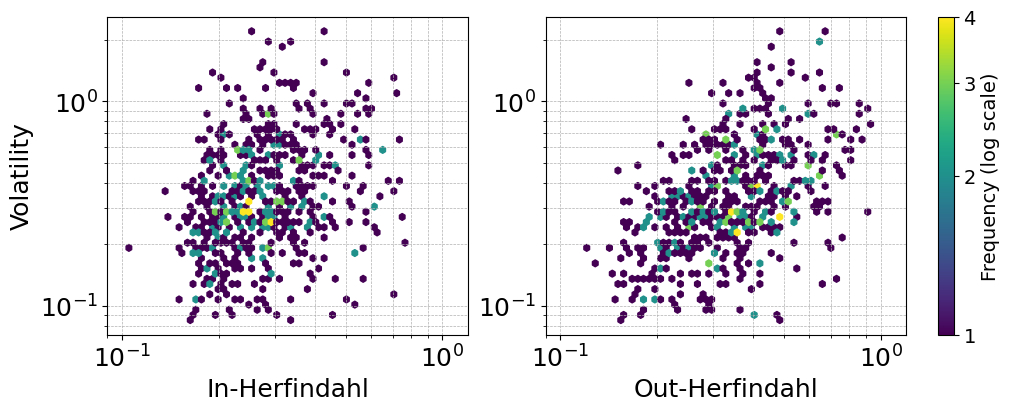

In [383]:
# Create a 1x2 grid with constrained layout
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Create the first hexbin plot
hb1 = axs[0].hexbin(Herf_agg_in['Herfind_Gab_in'][Herf_agg_in['Herfind_Gab_in']>0],Herf_agg_in['volatility'][Herf_agg_in['Herfind_Gab_in']>0], gridsize=50,bins='log', xscale='log', yscale='log')




#axs[0].set_title('Hexbin Plot 1')
axs[0].set_xlabel("In-Herfindahl",fontsize=18)
axs[0].set_ylabel(r'Volatility',fontsize=18)
axs[0].grid(True, which='both', linestyle='--', lw=0.5)



# Create the second hexbin plot
hb2 = axs[1].hexbin(Herf_agg_out['Herfind_Gab_out'][Herf_agg_out['Herfind']>0],Herf_agg_out['volatility'][Herf_agg_out['Herfind_Gab_out']>0], gridsize=50,bins='log', xscale='log', yscale='log')


#axs[1].set_title('Hexbin Plot 2')
axs[1].set_xlabel("Out-Herfindahl",fontsize=18)
#axs[1].set_ylabel(r'Volatility',fontsize=18)
axs[1].grid(True, which='both', linestyle='--', lw=0.5)


# Create a colorbar shared between both plots
cbar = plt.colorbar(hb2, ax=axs, fraction=0.03, pad=0.04)
cbar.set_label('Frequency (log scale)',fontsize=14)

# Define the specific tick locations and labels you want
custom_ticks = [1, 2, 3, 4]
custom_labels = ['1', '2', '3', '4']

# Set the colorbar ticks and labels
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels(custom_labels)
cbar.ax.yaxis.set_tick_params(labelsize=14)  # Adjust the fontsize (change 14 to your desired size)



tick_size = 18  # Set your desired tick size


for ax in axs:
    ax.tick_params(axis='both', which='both', labelsize=tick_size)
    #ax.tick_params(axis='both', which='both', length=2, width=2)

# Set the same x-range for both subplots
common_xlim = (0.9*10**(-1), 1.2)  # Set your desired x-range
for ax in axs:
    ax.set_xlim(common_xlim)


#plt.suptitle('Side-by-Side Hexbin Plots with Shared Colorbar')
plt.savefig('plots/mean_volatility_sample_vs_Herfindahl_agg_Hexbin.png',bbox_inches='tight')
plt.show()


In [801]:
##### Defining a function that bins with equal number of data points
def equal_frequency_binning(data, num_bins):
    # Calculate quantiles to determine bin edges
    quantiles = np.linspace(0, 1, num_bins + 1)
    bin_edges = np.quantile(data, quantiles)

    # Assign each data point to the corresponding bin
    binned_data = np.digitize(data, bin_edges)

    return binned_data




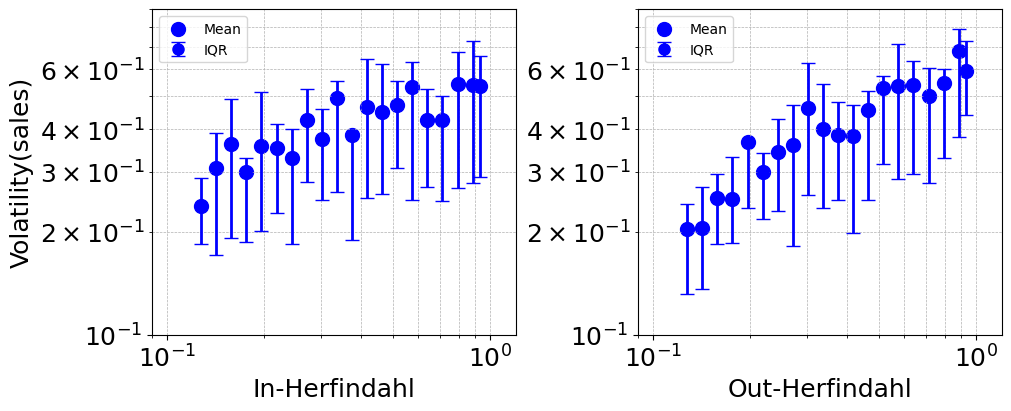

In [837]:
# Create a 1x2 grid with constrained layout
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Create the first hexbin plot




#axs[0].set_title('Hexbin Plot 1')
axs[0].set_xlabel("In-Herfindahl",fontsize=18)
axs[0].set_ylabel(r'Volatility(sales)',fontsize=18)
axs[0].grid(True, which='both', linestyle='--', lw=0.5)



# Define the number of logarithmic bins
num_bins = 20  # Change this to 3

# Create logarithmic bins using numpy
df_vol_degree['Herfind_Gab_in_Log_Bin'] = equal_frequency_binning(df_vol_degree['Herfind_Gab_in'],num_bins)

# Group by the 'X_Log_Bin' and calculate mean and quantiles of 'Y'
result = df_vol_degree.groupby('Herfind_Gab_in_Log_Bin')['Volatility(seas)'].agg(['mean', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])

# Create a log-log scatter plot
x = [np.mean(log_bins[i - 1:i + 1]) for i in result.index]  # Convert bin edges to bin centers
axs[0].scatter(x, result['mean'], label='Mean', color='blue', marker='o', s=100)
axs[0].errorbar(x, result['mean'], yerr=[np.abs(result['<lambda_0>'] - result['mean']) , np.abs(result['<lambda_1>'] - result['mean'])],
             fmt='o', color='blue', markersize=8, capsize=5, label='IQR', elinewidth=2)

# Customize the plot
axs[0].set_xscale('log')
axs[0].set_yscale('log')


# Create the second hexbin plot





# Define the number of logarithmic bins
num_bins = 20  # Change this to 3


df_vol_degree['Herfind_Gab_out_Log_Bin'] = equal_frequency_binning(df_vol_degree['Herfind_Gab_out'],num_bins)


# Group by the 'X_Log_Bin' and calculate mean and quantiles of 'Y'
result = df_vol_degree.groupby('Herfind_Gab_out_Log_Bin')['Volatility(seas)'].agg(['mean', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])



# Create a log-log scatter plot
x = [np.mean(log_bins[i - 1:i + 1]) for i in result.index]  # Convert bin edges to bin centers

axs[1].scatter(x, result['mean'], label='Mean', color='blue', marker='o', s=100)
axs[1].errorbar(x, result['mean'], yerr=[np.abs(result['<lambda_0>'] - result['mean']) , np.abs(result['<lambda_1>'] - result['mean'])],
             fmt='o', color='blue', markersize=8, capsize=5, label='IQR', elinewidth=2)


# Customize the plot
axs[1].set_xscale('log')
axs[1].set_yscale('log')



#axs[1].set_title('Hexbin Plot 2')
axs[1].set_xlabel("Out-Herfindahl",fontsize=18)
#axs[1].set_ylabel(r'Volatility',fontsize=18)
axs[1].grid(True, which='both', linestyle='--', lw=0.5)


axs[1].legend()
axs[0].legend()


tick_size = 18  # Set your desired tick size


for ax in axs:
    ax.tick_params(axis='both', which='both', labelsize=tick_size)
    #ax.tick_params(axis='both', which='both', length=2, width=2)

# Set the same x-range for both subplots
common_xlim = (0.9*10**(-1), 1.2)  # Set your desired x-range
for ax in axs:
    ax.set_xlim(common_xlim)
    
common_ylim = (1*10**(-1), 9*10**-1)  # Set your desired x-range
for ax in axs:
    ax.set_ylim(common_ylim)


#plt.suptitle('Side-by-Side Hexbin Plots with Shared Colorbar')
plt.savefig('plots/mean_volatility_sample_vs_Herfindahl_agg_binning_equal.png',bbox_inches='tight')
plt.show()


##### Using Log-bins

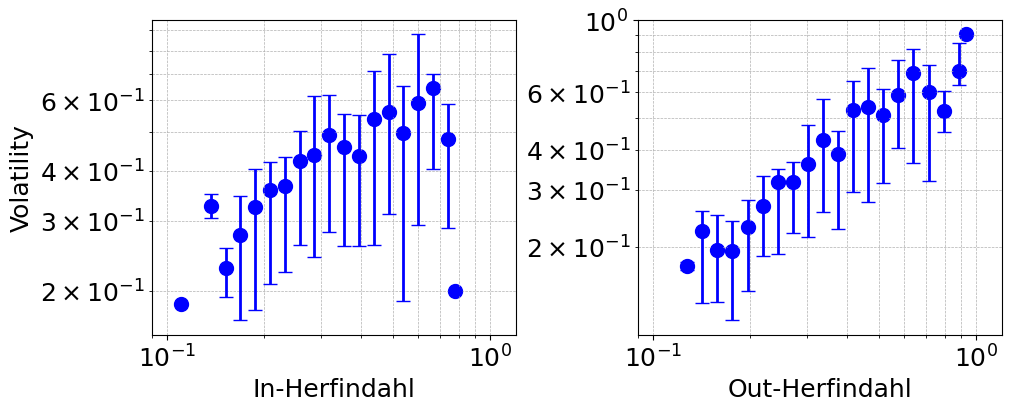

In [749]:
# Create a 1x2 grid with constrained layout
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Create the first hexbin plot




#axs[0].set_title('Hexbin Plot 1')
axs[0].set_xlabel("In-Herfindahl",fontsize=18)
axs[0].set_ylabel(r'Volatility',fontsize=18)
axs[0].grid(True, which='both', linestyle='--', lw=0.5)



# Define the number of logarithmic bins
num_bins = 20  # Change this to 3

# Create logarithmic bins using numpy
log_bins = np.logspace(np.log10(df_vol_degree['Herfind_Gab_in'].min()), np.log10(df_vol_degree['Herfind_Gab_in'].max()), num_bins)
df_vol_degree['Herfind_Gab_in_Log_Bin'] = np.digitize(df_vol_degree['Herfind_Gab_in'], log_bins)

# Group by the 'X_Log_Bin' and calculate mean and quantiles of 'Y'
result = df_vol_degree.groupby('Herfind_Gab_in_Log_Bin')['Volatility(seas)'].agg(['mean', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])

# Create a log-log scatter plot
x = [np.mean(log_bins[i - 1:i + 1]) for i in result.index]  # Convert bin edges to bin centers
axs[0].scatter(x, result['mean'], label='Mean', color='blue', marker='o', s=100)
axs[0].errorbar(x, result['mean'], yerr=[np.abs(result['<lambda_0>'] - result['mean']) , np.abs(result['<lambda_1>'] - result['mean'])],
             fmt='o', color='blue', markersize=8, capsize=5, label='IQR', elinewidth=2)

# Customize the plot
axs[0].set_xscale('log')
axs[0].set_yscale('log')


# Create the second hexbin plot












#axs[1].set_title('Hexbin Plot 2')
axs[1].set_xlabel("Out-Herfindahl",fontsize=18)
#axs[1].set_ylabel(r'Volatility',fontsize=18)
axs[1].grid(True, which='both', linestyle='--', lw=0.5)


# Define the number of logarithmic bins
num_bins = 20  # Change this to 3

# Create logarithmic bins using numpy
log_bins = np.logspace(np.log10(df_vol_degree['Herfind_Gab_out'].min()), np.log10(df_vol_degree['Herfind_Gab_out'].max()), num_bins)
df_vol_degree['Herfind_Gab_out_Log_Bin'] = np.digitize(df_vol_degree['Herfind_Gab_out'], log_bins)

# Group by the 'X_Log_Bin' and calculate mean and quantiles of 'Y'
result = df_vol_degree.groupby('Herfind_Gab_out_Log_Bin')['Volatility(seas)'].agg(['mean', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])

# Create a log-log scatter plot
x = [np.mean(log_bins[i - 1:i + 1]) for i in result.index]  # Convert bin edges to bin centers
axs[1].scatter(x, result['mean'], label='Mean', color='blue', marker='o', s=100)
axs[1].errorbar(x, result['mean'], yerr=[np.abs(result['<lambda_0>'] - result['mean']) , np.abs(result['<lambda_1>'] - result['mean'])],
             fmt='o', color='blue', markersize=8, capsize=5, label='IQR', elinewidth=2)

# Customize the plot
axs[1].set_xscale('log')
axs[1].set_yscale('log')

tick_size = 18  # Set your desired tick size


for ax in axs:
    ax.tick_params(axis='both', which='both', labelsize=tick_size)
    #ax.tick_params(axis='both', which='both', length=2, width=2)

# Set the same x-range for both subplots
common_xlim = (0.9*10**(-1), 1.2)  # Set your desired x-range
for ax in axs:
    ax.set_xlim(common_xlim)


#plt.suptitle('Side-by-Side Hexbin Plots with Shared Colorbar')
#plt.savefig('plots/mean_volatility_sample_vs_Herfindahl_agg_Hexbin.png',bbox_inches='tight')
plt.show()


##### More analysis on Volatility vs Herfindahl

In the following we are going to pick industries with a certain degree range, say $k_i\in [9,11]$ and do a scatter plot of volatility against Herfindahl.

This is to see that for a given degree volatility depends on Herfindahl

In [392]:
Herf_agg_in['in_degree'] = df_vol_degree['in_degree']
Herf_agg_out['out_degree'] = df_vol_degree['out_degree']


In [163]:
Herf_2015_in['in_degree'] = df_vol_degree['in_degree']
Herf_2016_in['in_degree'] = df_vol_degree['in_degree']
Herf_2017_in['in_degree'] = df_vol_degree['in_degree']
Herf_2018_in['in_degree'] = df_vol_degree['in_degree']
Herf_2019_in['in_degree'] = df_vol_degree['in_degree']
Herf_2020_in['in_degree'] = df_vol_degree['in_degree']
Herf_2021_in['in_degree'] = df_vol_degree['in_degree']

In [164]:
Herf_2015_out['out_degree'] = df_vol_degree['out_degree']
Herf_2016_out['out_degree'] = df_vol_degree['out_degree']
Herf_2017_out['out_degree'] = df_vol_degree['out_degree']
Herf_2018_out['out_degree'] = df_vol_degree['out_degree']
Herf_2019_out['out_degree'] = df_vol_degree['out_degree']
Herf_2020_out['out_degree'] = df_vol_degree['out_degree']
Herf_2021_out['out_degree'] = df_vol_degree['out_degree']

In [413]:
# Define your bin range


bin_min = 80
bin_max = 100

# Select rows within the specified bin range
selected_Herf_out = Herf_agg_out[(Herf_agg_out['out_degree'] >= bin_min) & (Herf_agg_out['out_degree'] <= bin_max)]



In [414]:
# Define your bin range
#bin_min = 10
#bin_max = 80

bin_min = 80
bin_max = 100

# Select rows within the specified bin range
selected_Herf_in = Herf_agg_in[(Herf_agg_in['in_degree'] >= bin_min) & (Herf_agg_in['in_degree'] <= bin_max)]




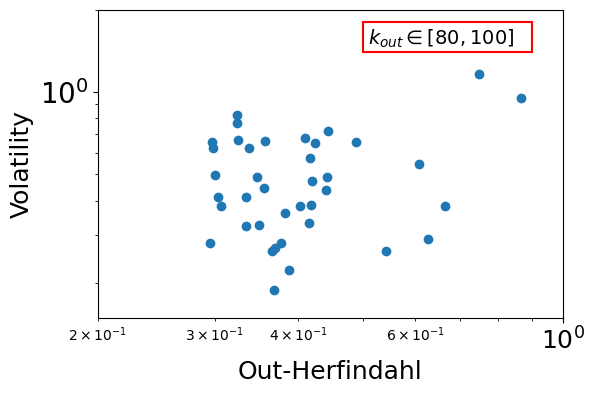

In [450]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(6, 4))

scatter_labels = ['Volatility at different times'] 

# Create a binned scatterplot with hexbins
plt.scatter(selected_Herf_out['Herfind_Gab_out'][selected_Herf_out['Herfind_Gab_out']>0],selected_Herf_out['volatility'][selected_Herf_out['Herfind_Gab_out']>0])


#red_dot = mlines.Line2D([], [], color='black', marker='o', linestyle='None',linewidth=10,
#                          markersize=5, label='Volatility at \ndifferent times')

#blue_line = mlines.Line2D([], [], color='blue', marker='None', linestyle='-',linewidth=3,
#                          markersize=0.01, label='Power-Law Fit')

#plt.legend(handles=[red_dot,blue_line],fontsize = 14, frameon = False)

#x = np.linspace(4, 5654, 1000)
#plt.loglog(x, f_all(x), color='blue',linewidth=4,label='f_all')
# Add labels and title
plt.xlabel("Out-Herfindahl",fontsize=18)
plt.ylabel(r'Volatility',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Define the text and position for your box
box_text = "$k_{out}\in [80,100]$"
box_x = 0.5  # Adjust the x-coordinate
box_y = 1.4  # Adjust the y-coordinate
box_width = 0.4
box_height = 0.4

# Create a Rectangle patch to represent the box
legend_box = Rectangle((box_x, box_y), box_width, box_height,
                       linewidth=1.5, edgecolor='r', facecolor='none')

# Add the Rectangle patch to the plot
ax.add_patch(legend_box)

# Add text to the box
ax.text(box_x + 0.01, box_y + 0.09, box_text, fontsize=14)

plt.xscale('log')
plt.yscale('log')
#plt.legend()

ax.tick_params(axis='y', labelsize=20)  # Adjust the font size (change 12 to your desired size)

#plt.rcParams['ytick.labelsize'] = 10
# Adjust the font size (change 12 to your desired size)
plt.xlim(2*10**-1, 1)  # Set the x-axis range (limits)
plt.ylim(0.15, 2)  # Set the y-axis range (limits)
# Add a colorbar
plt.savefig('plots/volatility_sample_vs_outHerf_fixed_degree.png',bbox_inches='tight')


# Show the plot
plt.show()

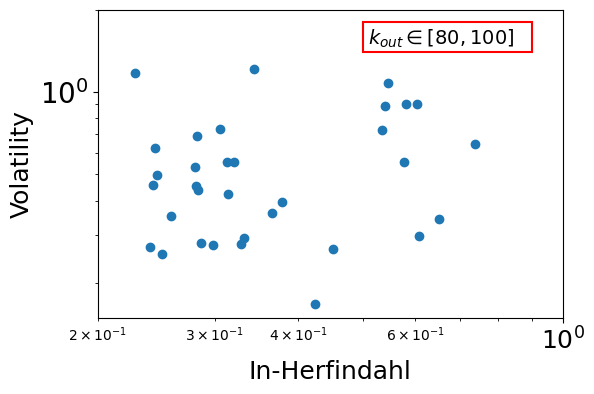

In [449]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(6, 4))
scatter_labels = ['Volatility at different times'] 

# Create a binned scatterplot with hexbins
plt.scatter(selected_Herf_in['Herfind_Gab_in'][selected_Herf_in['Herfind_Gab_in']>0],selected_Herf_in['volatility'][selected_Herf_in['Herfind_Gab_in']>0])


#red_dot = mlines.Line2D([], [], color='black', marker='o', linestyle='None',linewidth=10,
#                          markersize=5, label='Volatility at \ndifferent times')

#blue_line = mlines.Line2D([], [], color='blue', marker='None', linestyle='-',linewidth=3,
#                          markersize=0.01, label='Power-Law Fit')

#plt.legend(handles=[red_dot,blue_line],fontsize = 14, frameon = False)

#x = np.linspace(4, 5654, 1000)
#plt.loglog(x, f_all(x), color='blue',linewidth=4,label='f_all')
# Add labels and title
plt.xlabel("In-Herfindahl",fontsize=18)
plt.ylabel(r'Volatility',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Define the text and position for your box
box_text = "$k_{out}\in [80,100]$"
box_x = 0.5  # Adjust the x-coordinate
box_y = 1.4  # Adjust the y-coordinate
box_width = 0.4
box_height = 0.4

# Create a Rectangle patch to represent the box
legend_box = Rectangle((box_x, box_y), box_width, box_height,
                       linewidth=1.5, edgecolor='r', facecolor='none')

# Add the Rectangle patch to the plot
ax.add_patch(legend_box)

# Add text to the box
ax.text(box_x + 0.01, box_y + 0.09, box_text, fontsize=14)

plt.xscale('log')
plt.yscale('log')
#plt.legend()

ax.tick_params(axis='y', labelsize=20)  # Adjust the font size (change 12 to your desired size)

#plt.rcParams['ytick.labelsize'] = 10
# Adjust the font size (change 12 to your desired size)

plt.xlim(2*10**-1, 1)  # Set the x-axis range (limits)
plt.ylim(0.15, 2)  # Set the y-axis range (limits)

# Add a colorbar
plt.savefig('plots/volatility_sample_vs_inHerf_fixed_degree.png',bbox_inches='tight')


# Show the plot
plt.show()

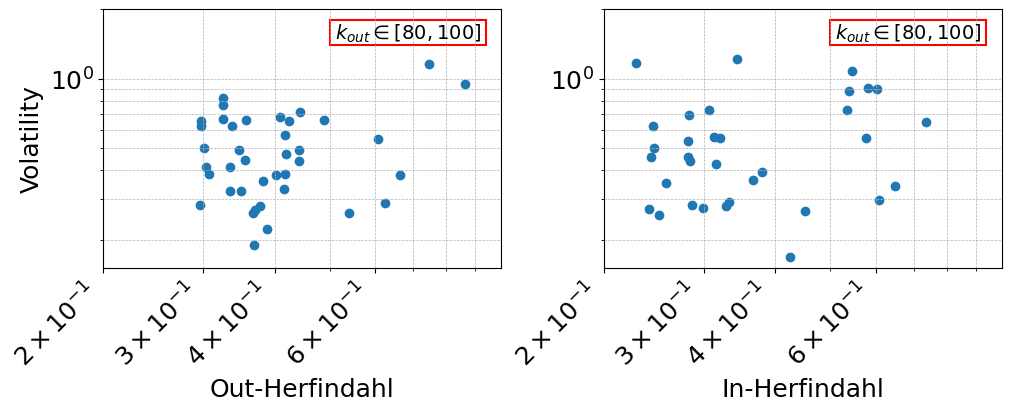

In [525]:
# Create a 1x2 grid with constrained layout
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Create the first hexbin plot
hb1 = axs[0].scatter(selected_Herf_out['Herfind_Gab_out'][selected_Herf_out['Herfind_Gab_out']>0],selected_Herf_out['volatility'][selected_Herf_out['Herfind_Gab_out']>0])


scatter_labels = ['Volatility at different times'] 

# Create a binned scatterplot with hexbins



#axs[0].set_title('Hexbin Plot 1')
axs[0].set_xlabel("Out-Herfindahl",fontsize=18)
axs[0].set_ylabel(r'Volatility',fontsize=18)
axs[0].grid(True, which='both', linestyle='--', lw=0.5)




# Define the text and position for your box
box_text = "$k_{out}\in [80,100]$"
box_x = 0.5  # Adjust the x-coordinate
box_y = 1.4  # Adjust the y-coordinate
box_width = 0.44
box_height = 0.4

# Create a Rectangle patch to represent the box
legend_box = Rectangle((box_x, box_y), box_width, box_height,
                       linewidth=1.5, edgecolor='r', facecolor='none')

# Add the Rectangle patch to the plot
axs[0].add_patch(legend_box)

# Add text to the box
axs[0].text(box_x + 0.01, box_y + 0.09, box_text, fontsize=14)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim(9*10**-4, 1)
#plt.legend()

#ax.tick_params(axis='y', labelsize=20)  # Adjust the font size (change 12 to your desired size)







# Create the second hexbin plot
hb2 = axs[1].scatter(selected_Herf_in['Herfind_Gab_in'][selected_Herf_in['Herfind_Gab_in']>0],selected_Herf_in['volatility'][selected_Herf_in['Herfind_Gab_in']>0])


#axs[1].set_title('Hexbin Plot 2')
axs[1].set_xlabel("In-Herfindahl",fontsize=18)
#axs[1].set_ylabel(r'Volatility',fontsize=18)
axs[1].grid(True, which='both', linestyle='--', lw=0.5)


axs[1].set_xscale('log')
axs[1].set_yscale('log')
tick_size = 18  # Set your desired tick size


legend_box2 = Rectangle((box_x, box_y), box_width, box_height,
                       linewidth=1.5, edgecolor='r', facecolor='none')

# Add the Rectangle patch to the plot
axs[1].add_patch(legend_box2)

# Add text to the box
axs[1].text(box_x + 0.01, box_y + 0.09, box_text, fontsize=14)



for ax in axs:
    ax.tick_params(axis='both', which='both', labelsize=tick_size)
    #ax.tick_params(axis='both', which='both', length=2, width=2)

# Set the same x-range for both subplots
common_xlim = (2*10**-1, 1)  # Set your desired x-range
for ax in axs:
    ax.set_xlim(common_xlim)
    #ax.set_xticks([2*10**-1, 6*10**-1], [r"$2\times 10^{-1}$",r"$6\times 10^{-1}$"])
    ax.set_xticks([2*10**-1,3*10**-1, 4*10**-1,6*10**-1], [r"$2\times 10^{-1}$",r"$3\times 10^{-1}$",r"$4\times 10^{-1}$",r"$6\times 10^{-1}$"], rotation=45, ha='right')
    #ax.set_xticks(ax.get_xticks())
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Set the same x-range for both subplots
common_ylim = (0.15, 2)  # Set your desired x-range
for ax in axs:
    ax.set_ylim(common_ylim)
    

#plt.suptitle('Side-by-Side Hexbin Plots with Shared Colorbar')
plt.savefig('plots/mean_volatility_sample_vs_Herfindahl_fixed_deg.png',bbox_inches='tight')
plt.show()


## Volatility vs Centrality

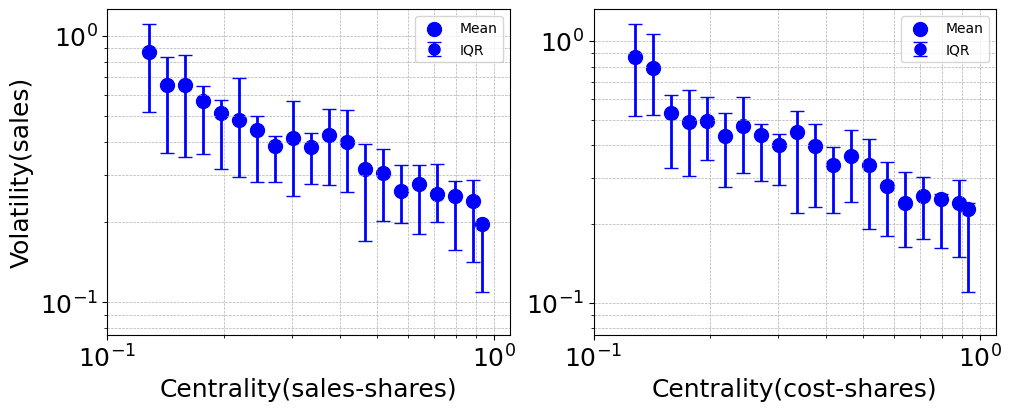

In [836]:
# Create a 1x2 grid with constrained layout
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)




#axs[0].set_title('Hexbin Plot 1')
axs[0].set_xlabel("Centrality(sales-shares)",fontsize=18)
axs[0].set_ylabel(r'Volatility(sales)',fontsize=18)
axs[0].grid(True, which='both', linestyle='--', lw=0.5)






# Define the number of logarithmic bins
num_bins = 20  # Change this to 3

# Create logarithmic bins using numpy
df_vol_degree['centrality_Log_Bin'] = equal_frequency_binning(df_vol_degree['centrality'],num_bins)

# Group by the 'X_Log_Bin' and calculate mean and quantiles of 'Y'
result = df_vol_degree.groupby('centrality_Log_Bin')['Volatility(seas)'].agg(['mean', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])

# Create a log-log scatter plot
x = [np.mean(log_bins[i - 1:i + 1]) for i in result.index]  # Convert bin edges to bin centers
axs[0].scatter(x, result['mean'], label='Mean', color='blue', marker='o', s=100)
axs[0].errorbar(x, result['mean'], yerr=[np.abs(result['<lambda_0>'] - result['mean']) , np.abs(result['<lambda_1>'] - result['mean'])],
             fmt='o', color='blue', markersize=8, capsize=5, label='IQR', elinewidth=2)

# Customize the plot
axs[0].set_xscale('log')
axs[0].set_yscale('log')







#axs[1].set_title('Hexbin Plot 2')
axs[1].set_xlabel("Centrality(cost-shares)",fontsize=18)
#axs[1].set_ylabel(r'Volatility',fontsize=18)
axs[1].grid(True, which='both', linestyle='--', lw=0.5)




# Define the number of logarithmic bins
num_bins = 20  # Change this to 3

# Create logarithmic bins using numpy
df_vol_degree['centrality_sales_Log_Bin'] = equal_frequency_binning(df_vol_degree['centrality_sales'],num_bins)

# Group by the 'X_Log_Bin' and calculate mean and quantiles of 'Y'
result = df_vol_degree.groupby('centrality_sales_Log_Bin')['Volatility(seas)'].agg(['mean', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])

# Create a log-log scatter plot
x = [np.mean(log_bins[i - 1:i + 1]) for i in result.index]  # Convert bin edges to bin centers
axs[1].scatter(x, result['mean'], label='Mean', color='blue', marker='o', s=100)
axs[1].errorbar(x, result['mean'], yerr=[np.abs(result['<lambda_0>'] - result['mean']) , np.abs(result['<lambda_1>'] - result['mean'])],
             fmt='o', color='blue', markersize=8, capsize=5, label='IQR', elinewidth=2)

# Customize the plot
axs[1].set_xscale('log')
axs[1].set_yscale('log')




axs[1].legend()
axs[0].legend()


for ax in axs:
    ax.tick_params(axis='both', which='both', labelsize=tick_size)
    #ax.tick_params(axis='both', which='both', length=2, width=2)

# Set the same x-range for both subplots
common_xlim = (1*10**(-1), 11*10**(-1))  # Set your desired x-range
for ax in axs:
    ax.set_xlim(common_xlim)


#plt.suptitle('Side-by-Side Hexbin Plots with Shared Colorbar')
plt.savefig('plots/mean_volatility_sample_vs_centrality_bin_equal.png',bbox_inches='tight')
plt.show()


# Time-varying volatility

To compute time-varying volatility from a time series, you need to estimate the volatility for each time period in the series, resulting in a time-varying sequence of volatility values. Here's a simplified manual procedure for calculating time-varying volatility:

    1) Select a Rolling Window: Choose a fixed-size rolling window, often  
    referred to as the estimation window. This window slides along the time series, covering a specific number of past observations.

    2) Estimate Volatility: Within the rolling window, estimate the volatility of the data contained in that window. Common methods include:

Standard Deviation: Calculate the standard deviation of the data in the window.

    3) Slide the Window: Move the rolling window forward one time step (e.g., one day for daily data) and repeat the estimation process.

    4) Time Series of Volatility: As you repeat this process, you will accumulate a time series of volatility estimates. Each data point in this time series corresponds to the estimated volatility within the rolling window for that specific time point.

We have computed the time-varying volatility in a 13 month sliding window.

i.e. month-year to month-year+1 is one window

and then we keep sliding.

###### Computing Monthly Katz-Bonacich centralities

In [175]:
aggregate_output_SIC5_non_zero  = aggregate_output_SIC5[(aggregate_output_SIC5 != 0).all(axis=1)]
result_SIC5_V3_amt_non_zero = result_SIC5_V3_amt[(result_SIC5_V3_amt != 0).all(axis=1)]

In [177]:
nodelist_harm = result_SIC5_V3_amt_non_zero['to_pn'].unique()

Z_ij_pluto = []
for col in result_SIC5_V3_amt_non_zero.drop(columns = ['from_pn','to_pn']).columns:
    G_pluto_harm = nx.from_pandas_edgelist(result_SIC5_V3_amt_non_zero,'from_pn','to_pn',col,create_using=nx.DiGraph())
    Adjtraining_pluto_harm = nx.adjacency_matrix(G_pluto_harm, nodelist = nodelist_harm,weight=col)
    Z_ij_pluto.append(Adjtraining_pluto_harm.todense())


/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/4081370105.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Adjtraining_pluto_harm = nx.adjacency_matrix(G_pluto_harm, nodelist = nodelist_harm,weight=col)


In [178]:
Bonacich_centrality_pluto = []

for i in range(len(Z_ij_pluto)):
    col_sum_zij_pluto = np.sum(Z_ij_pluto[i],axis = 0)

##### Note that here we are computing the transpose of W (the input shares matrix)
    X_ij_pluto = Z_ij_pluto[i].dot(np.diag(1/np.ravel(col_sum_zij_pluto)))
    
    alpha = 0.5
    lamb = alpha
    eta = (1-alpha)/len(X_ij_pluto)


    Bonacich_centrality_pluto.append((eta*(np.linalg.inv(np.eye(len(X_ij_pluto))-lamb*X_ij_pluto))).dot(np.ones((len(X_ij_pluto),1))))



###### Computing Monthly Degrees

In [179]:

# Use the apply method to apply the custom function to each column
new_columns = result_SIC5_V3_amt.drop(['from_pn','to_pn'],axis =1).applymap(lambda x: 1 if x > 0 else 0)

# Concatenate the new columns to the original DataFrame
df_degree_month = pd.concat([result_SIC5_V3_amt, new_columns], axis=1)

# You can rename the new columns if needed
new_column_names = [col + '_deg' for col in result_SIC5_V3_amt.drop(['from_pn','to_pn'],axis =1).columns]
df_degree_month.columns = list(result_SIC5_V3_amt.columns) + new_column_names

# Now, result_df contains the original columns and additional columns with the values doubled.


/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/1539445423.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_columns = result_SIC5_V3_amt.drop(['from_pn','to_pn'],axis =1).applymap(lambda x: 1 if x > 0 else 0)


In [180]:
outdegree_month = pd.concat([df_degree_month['from_pn'],df_degree_month[[col + '_deg' for col in result_SIC5_V3_amt.drop(['from_pn','to_pn'],axis =1).columns]]],axis = 1).groupby('from_pn').sum()

indegree_month = pd.concat([df_degree_month['to_pn'],df_degree_month[[col + '_deg' for col in result_SIC5_V3_amt.drop(['from_pn','to_pn'],axis =1).columns]]],axis = 1).groupby('to_pn').sum()




           

###### Computing Monthly Herfindahl

In [187]:
Z_2015_rel_in = pd.merge(SIC5_yearly[['from_pn','2015']],SIC5_yearly.groupby('from_pn')['2015'].agg('sum'),on="from_pn")
Z_2016_rel_in = pd.merge(SIC5_yearly[['from_pn','2016']],SIC5_yearly.groupby('from_pn')['2016'].agg('sum'),on="from_pn")
Z_2017_rel_in = pd.merge(SIC5_yearly[['from_pn','2017']],SIC5_yearly.groupby('from_pn')['2017'].agg('sum'),on="from_pn")
Z_2018_rel_in = pd.merge(SIC5_yearly[['from_pn','2018']],SIC5_yearly.groupby('from_pn')['2018'].agg('sum'),on="from_pn")
Z_2019_rel_in = pd.merge(SIC5_yearly[['from_pn','2019']],SIC5_yearly.groupby('from_pn')['2019'].agg('sum'),on="from_pn")
Z_2020_rel_in = pd.merge(SIC5_yearly[['from_pn','2020']],SIC5_yearly.groupby('from_pn')['2020'].agg('sum'),on="from_pn")
Z_2021_rel_in = pd.merge(SIC5_yearly[['from_pn','2021']],SIC5_yearly.groupby('from_pn')['2021'].agg('sum'),on="from_pn")

Z_2015_rel_in = Z_2015_rel_in.rename(columns={"2015_x": "Transaction", "2015_y": "Industry_Input"})
Z_2016_rel_in = Z_2016_rel_in.rename(columns={"2016_x": "Transaction", "2016_y": "Industry_Input"})
Z_2017_rel_in = Z_2017_rel_in.rename(columns={"2017_x": "Transaction", "2017_y": "Industry_Input"})
Z_2018_rel_in = Z_2018_rel_in.rename(columns={"2018_x": "Transaction", "2018_y": "Industry_Input"})
Z_2019_rel_in = Z_2019_rel_in.rename(columns={"2019_x": "Transaction", "2019_y": "Industry_Input"})
Z_2020_rel_in = Z_2020_rel_in.rename(columns={"2020_x": "Transaction", "2020_y": "Industry_Input"})
Z_2021_rel_in = Z_2021_rel_in.rename(columns={"2021_x": "Transaction", "2021_y": "Industry_Input"})

Z_2015_rel_in['Share'] = Z_2015_rel_in['Transaction']/Z_2015_rel_in['Industry_Input']
Z_2016_rel_in['Share'] = Z_2016_rel_in['Transaction']/Z_2016_rel_in['Industry_Input']
Z_2017_rel_in['Share'] = Z_2017_rel_in['Transaction']/Z_2017_rel_in['Industry_Input']
Z_2018_rel_in['Share'] = Z_2018_rel_in['Transaction']/Z_2018_rel_in['Industry_Input']
Z_2019_rel_in['Share'] = Z_2019_rel_in['Transaction']/Z_2019_rel_in['Industry_Input']
Z_2020_rel_in['Share'] = Z_2020_rel_in['Transaction']/Z_2020_rel_in['Industry_Input']
Z_2021_rel_in['Share'] = Z_2021_rel_in['Transaction']/Z_2021_rel_in['Industry_Input']


In [188]:
Herfind_In = pd.merge(result_SIC5_V3_amt.drop(['from_pn'],axis =1),result_SIC5_V3_amt.drop(['from_pn'],axis =1).groupby('to_pn').agg('sum'),on="to_pn")
Herfind_Out = pd.merge(result_SIC5_V3_amt.drop(['to_pn'],axis =1),result_SIC5_V3_amt.drop(['to_pn'],axis =1).groupby('from_pn').agg('sum'),on="from_pn")




In [189]:
# Get unique common parts (strings before '_x' or '_y')
common_parts = set(col.split('_x')[0] for col in Herfind_In.columns if '_x' in col)

# Create a new DataFrame to store the results
result_df_in = pd.DataFrame()
result_df_out = pd.DataFrame()

# Iterate through unique common parts
for common_part in common_parts:
    # Find matching columns with '_x' and '_y'
    x_col = f"{common_part}_x"
    y_col = f"{common_part}_y"

    # Check if both columns exist
    if x_col in Herfind_In.columns and y_col in Herfind_In.columns:
        # Divide '_x' column by '_y' column and store the result in a new column
        result_df_in[common_part] = Herfind_In[x_col] / Herfind_In[y_col]

    # Check if both columns exist
    if x_col in Herfind_Out.columns and y_col in Herfind_Out.columns:
        # Divide '_x' column by '_y' column and store the result in a new column
        result_df_out[common_part] = Herfind_Out[x_col] / Herfind_Out[y_col]

In [190]:
result_df_in =  result_df_in[result_SIC5_V3_amt.drop(['from_pn','to_pn'],axis =1).columns]
result_df_out =  result_df_out[result_SIC5_V3_amt.drop(['from_pn','to_pn'],axis =1).columns]

In [191]:
result_df_in['to_pn'] = Herfind_In['to_pn']
result_df_out['from_pn'] = Herfind_Out['from_pn']


In [192]:
result_df_in = result_df_in[~result_df_in['to_pn'].str.contains('84100')]
result_df_out = result_df_out[~result_df_out['from_pn'].str.contains('84100')]

In [193]:
# Create new columns with squared values
for column in result_df_out.drop(['from_pn'],axis =1).columns:
    new_column_name = column + '_squared'
    result_df_out.loc[:, new_column_name] = result_df_out[column] ** 2

/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/2963469583.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df_out.loc[:, new_column_name] = result_df_out[column] ** 2
/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/2963469583.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df_out.loc[:, new_column_name] = result_df_out[column] ** 2
/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/2963469583.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is u

In [194]:
# Create new columns with squared values
for column in result_df_in.drop(['to_pn'],axis =1).columns:
    new_column_name = column + '_squared'
    result_df_in.loc[:, new_column_name] = result_df_in[column] ** 2

/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/1180693973.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df_in.loc[:, new_column_name] = result_df_in[column] ** 2
/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/1180693973.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df_in.loc[:, new_column_name] = result_df_in[column] ** 2
/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/1180693973.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usual

/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/1180693973.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df_in.loc[:, new_column_name] = result_df_in[column] ** 2
/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/1180693973.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df_in.loc[:, new_column_name] = result_df_in[column] ** 2
/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/1180693973.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usual

In [195]:
# Create a list of columns to keep (those containing "_squared")
columns_to_keep = [col for col in result_df_in.groupby('to_pn').sum().columns if '_squared' in col]

# Create a new DataFrame with only the selected columns
Herfind_In = result_df_in.groupby('to_pn').sum()[columns_to_keep]
Herfind_Out = result_df_out.groupby('from_pn').sum()[columns_to_keep]

In [197]:
Herfind_In_Gabaix = np.sqrt(Herfind_In)
Herfind_Out_Gabaix = np.sqrt(Herfind_Out)

In [198]:


index_of_specific_column = Herfind_Out.columns.get_loc('jan_amt_16_squared')

# Select all columns to the right of 'specific_column'
Herfind_Out_79_months = Herfind_Out.iloc[:, index_of_specific_column :]
Herfind_In_79_months = Herfind_In.iloc[:, index_of_specific_column :]

result_SIC5_V3_amt_79_months = result_SIC5_V3_amt.drop(columns = ['from_pn','to_pn']).iloc[:, index_of_specific_column :]

outdegree_month_79 = outdegree_month.iloc[:, index_of_specific_column :]
indegree_month_79 = indegree_month.iloc[:, index_of_specific_column :]



In [199]:
index_of_specific_column = Herfind_Out.columns.get_loc('jul_amt_15_squared')

# Select all columns to the right of 'specific_column'
Herfind_Out_79_months_mid = Herfind_Out.iloc[:, index_of_specific_column :len(Herfind_Out.T) - index_of_specific_column]
Herfind_In_79_months_mid = Herfind_In.iloc[:, index_of_specific_column :len(Herfind_Out.T) - index_of_specific_column]

result_SIC5_V3_amt_79_months_mid = result_SIC5_V3_amt.drop(columns = ['from_pn','to_pn']).iloc[:, index_of_specific_column :len(Herfind_Out.T) - index_of_specific_column]

outdegree_month_79_mid = outdegree_month.iloc[:, index_of_specific_column :len(Herfind_Out.T) - index_of_specific_column]
indegree_month_79_mid = indegree_month.iloc[:, index_of_specific_column :len(Herfind_Out.T) - index_of_specific_column]


In [200]:
index_of_specific_column = Herfind_Out.columns.get_loc('feb_amt_15_squared')

# Select all columns to the right of 'specific_column'
Herfind_Out_79_months_ap = Herfind_Out.iloc[:, index_of_specific_column :len(Herfind_Out.T) - 12 +1]
Herfind_In_79_months_ap = Herfind_In.iloc[:, index_of_specific_column :len(Herfind_Out.T) - 12 + 1]

result_SIC5_V3_amt_79_months_ap = result_SIC5_V3_amt.drop(columns = ['from_pn','to_pn']).iloc[:, index_of_specific_column :len(Herfind_Out.T) - 12+ 1]

outdegree_month_79_ap = outdegree_month.iloc[:, index_of_specific_column :len(Herfind_Out.T) - 12 + 1]
indegree_month_79_ap = indegree_month.iloc[:, index_of_specific_column :len(Herfind_Out.T) - 12 + 1]


###### Deleting 84100 from growth time series

In [208]:
cs_firm_growth_time_series_613 = cs_firm_growth_time_series_seas.copy()
#cs_firm_growth_time_series_613 = cs_firm_growth_time_series_613.drop('84100', axis=0)

In [207]:
cs_firm_growth_time_series_mid_613 = cs_firm_growth_time_series_mid_seas.copy()
#cs_firm_growth_time_series_mid_613 = cs_firm_growth_time_series_mid_613.drop('84100', axis=0)

In [206]:
cs_firm_growth_time_series_ap_613 = cs_firm_growth_time_series_ap_seas.copy()
#cs_firm_growth_time_series_ap_613 = cs_firm_growth_time_series_ap_613.drop('84100', axis=0)

We have three panel datasets at the moment:

 - Fluctuations of growth rates (cs_firm_growth_time_series_613)
 - Monthly Out-Herfindahl (Herfind_Out)
 - Monthly Out-degrees (outdegree_month)


In [209]:
# Assuming df1 and df2 have the same number of columns

# Create a dictionary to map the column names from df1 to df2
column_mapping_1 = dict(zip(cs_firm_growth_time_series_613.columns, result_SIC5_V3_amt_79_months.columns))
column_mapping_2 = dict(zip(outdegree_month_79.columns, result_SIC5_V3_amt_79_months.columns))
column_mapping_3 = dict(zip(Herfind_Out_79_months.columns, result_SIC5_V3_amt_79_months.columns))

column_mapping_4 = dict(zip(indegree_month_79.columns, result_SIC5_V3_amt_79_months.columns))
column_mapping_5 = dict(zip(Herfind_In_79_months.columns, result_SIC5_V3_amt_79_months.columns))


# Rename the columns in df1 based on the mapping
cs_firm_growth_time_series_613.rename(columns=column_mapping_1, inplace=True)
outdegree_month_79.rename(columns=column_mapping_2, inplace=True)
Herfind_Out_79_months.rename(columns=column_mapping_3, inplace=True)

indegree_month_79.rename(columns=column_mapping_4, inplace=True)
Herfind_In_79_months.rename(columns=column_mapping_5, inplace=True)

/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/1324390963.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outdegree_month_79.rename(columns=column_mapping_2, inplace=True)
/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/1324390963.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indegree_month_79.rename(columns=column_mapping_4, inplace=True)


In [210]:
outdegree_month_79_transpose = outdegree_month_79.T.reset_index()
Herfind_Out_79_months_transpose = Herfind_Out_79_months.T.reset_index()
cs_firm_growth_time_series_613_transpose = cs_firm_growth_time_series_613.T.reset_index()

outdegree_month_79_transpose['index'] = outdegree_month_79_transpose['index'].str.replace('_amt_', '_')
outdegree_month_79_transpose['index'] = pd.to_datetime(outdegree_month_79_transpose['index'], format='%b_%y')

Herfind_Out_79_months_transpose['index'] = Herfind_Out_79_months_transpose['index'].str.replace('_amt_', '_')
Herfind_Out_79_months_transpose['index'] = pd.to_datetime(Herfind_Out_79_months_transpose['index'], format='%b_%y')


cs_firm_growth_time_series_613_transpose['index'] = cs_firm_growth_time_series_613_transpose['index'].str.replace('_amt_', '_')
cs_firm_growth_time_series_613_transpose['index'] = pd.to_datetime(cs_firm_growth_time_series_613_transpose['index'], format='%b_%y')



In [211]:
indegree_month_79_transpose = indegree_month_79.T.reset_index()
Herfind_In_79_months_transpose = Herfind_In_79_months.T.reset_index()

indegree_month_79_transpose['index'] = indegree_month_79_transpose['index'].str.replace('_amt_', '_')
indegree_month_79_transpose['index'] = pd.to_datetime(indegree_month_79_transpose['index'], format='%b_%y')

Herfind_In_79_months_transpose['index'] = Herfind_In_79_months_transpose['index'].str.replace('_amt_', '_')
Herfind_In_79_months_transpose['index'] = pd.to_datetime(Herfind_In_79_months_transpose['index'], format='%b_%y')


In [212]:
indegree_month_79_transpose = indegree_month_79_transpose.rename(columns={'index': "date"})
Herfind_In_79_months_transpose = Herfind_In_79_months_transpose.rename(columns={'index': "date"})

In [213]:
outdegree_month_79_transpose = outdegree_month_79_transpose.rename(columns={'index': "date"})
Herfind_Out_79_months_transpose = Herfind_Out_79_months_transpose.rename(columns={'index': "date"})
cs_firm_growth_time_series_613_transpose = cs_firm_growth_time_series_613_transpose.rename(columns={'index': "date"})


### Renaming a-priori and mid time-series

###### A priori 

In [230]:
# Assuming df1 and df2 have the same number of columns

# Create a dictionary to map the column names from df1 to df2
column_mapping_1 = dict(zip(cs_firm_growth_time_series_ap_613.columns, result_SIC5_V3_amt_79_months_ap.columns))
column_mapping_2 = dict(zip(outdegree_month_79_ap.columns, result_SIC5_V3_amt_79_months_ap.columns))
column_mapping_3 = dict(zip(Herfind_Out_79_months_ap.columns, result_SIC5_V3_amt_79_months_ap.columns))

column_mapping_4 = dict(zip(indegree_month_79_ap.columns, result_SIC5_V3_amt_79_months_ap.columns))
column_mapping_5 = dict(zip(Herfind_In_79_months_ap.columns, result_SIC5_V3_amt_79_months_ap.columns))


# Rename the columns in df1 based on the mapping
cs_firm_growth_time_series_ap_613.rename(columns=column_mapping_1, inplace=True)
outdegree_month_79_ap.rename(columns=column_mapping_2, inplace=True)
Herfind_Out_79_months_ap.rename(columns=column_mapping_3, inplace=True)

indegree_month_79_ap.rename(columns=column_mapping_4, inplace=True)
Herfind_In_79_months_ap.rename(columns=column_mapping_5, inplace=True)

/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/1842267231.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outdegree_month_79_ap.rename(columns=column_mapping_2, inplace=True)
/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/1842267231.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indegree_month_79_ap.rename(columns=column_mapping_4, inplace=True)


In [232]:
outdegree_month_79_transpose_ap = outdegree_month_79_ap.T.reset_index()
Herfind_Out_79_months_transpose_ap = Herfind_Out_79_months_ap.T.reset_index()

indegree_month_79_transpose_ap = indegree_month_79_ap.T.reset_index()
Herfind_In_79_months_transpose_ap = Herfind_In_79_months_ap.T.reset_index()

cs_firm_growth_time_series_613_transpose_ap = cs_firm_growth_time_series_ap_613.T.reset_index()

outdegree_month_79_transpose_ap['index'] = outdegree_month_79_transpose_ap['index'].str.replace('_amt_', '_')
outdegree_month_79_transpose_ap['index'] = pd.to_datetime(outdegree_month_79_transpose_ap['index'], format='%b_%y')

Herfind_Out_79_months_transpose_ap['index'] = Herfind_Out_79_months_transpose_ap['index'].str.replace('_amt_', '_')
Herfind_Out_79_months_transpose_ap['index'] = pd.to_datetime(Herfind_Out_79_months_transpose_ap['index'], format='%b_%y')




indegree_month_79_transpose_ap['index'] = indegree_month_79_transpose_ap['index'].str.replace('_amt_', '_')
indegree_month_79_transpose_ap['index'] = pd.to_datetime(indegree_month_79_transpose_ap['index'], format='%b_%y')

Herfind_In_79_months_transpose_ap['index'] = Herfind_In_79_months_transpose_ap['index'].str.replace('_amt_', '_')
Herfind_In_79_months_transpose_ap['index'] = pd.to_datetime(Herfind_In_79_months_transpose_ap['index'], format='%b_%y')






cs_firm_growth_time_series_613_transpose_ap['index'] = cs_firm_growth_time_series_613_transpose_ap['index'].str.replace('_amt_', '_')
cs_firm_growth_time_series_613_transpose_ap['index'] = pd.to_datetime(cs_firm_growth_time_series_613_transpose_ap['index'], format='%b_%y')



In [234]:
indegree_month_79_transpose_ap = indegree_month_79_transpose_ap.rename(columns={'index': "date"})
Herfind_In_79_months_transpose_ap = Herfind_In_79_months_transpose_ap.rename(columns={'index': "date"})

In [235]:
outdegree_month_79_transpose_ap = outdegree_month_79_transpose_ap.rename(columns={'index': "date"})
Herfind_Out_79_months_transpose_ap = Herfind_Out_79_months_transpose_ap.rename(columns={'index': "date"})
cs_firm_growth_time_series_613_transpose_ap = cs_firm_growth_time_series_613_transpose_ap.rename(columns={'index': "date"})


###### Middle

In [236]:
# Assuming df1 and df2 have the same number of columns

# Create a dictionary to map the column names from df1 to df2
column_mapping_1 = dict(zip(cs_firm_growth_time_series_mid_613.columns, result_SIC5_V3_amt_79_months_mid.columns))
column_mapping_2 = dict(zip(outdegree_month_79_mid.columns, result_SIC5_V3_amt_79_months_mid.columns))
column_mapping_3 = dict(zip(Herfind_Out_79_months_mid.columns, result_SIC5_V3_amt_79_months_mid.columns))

column_mapping_4 = dict(zip(indegree_month_79_mid.columns, result_SIC5_V3_amt_79_months_mid.columns))
column_mapping_5 = dict(zip(Herfind_In_79_months_mid.columns, result_SIC5_V3_amt_79_months_mid.columns))


# Rename the columns in df1 based on the mapping
cs_firm_growth_time_series_mid_613.rename(columns=column_mapping_1, inplace=True)
outdegree_month_79_mid.rename(columns=column_mapping_2, inplace=True)
Herfind_Out_79_months_mid.rename(columns=column_mapping_3, inplace=True)

indegree_month_79_mid.rename(columns=column_mapping_4, inplace=True)
Herfind_In_79_months_mid.rename(columns=column_mapping_5, inplace=True)



/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/3167351935.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outdegree_month_79_mid.rename(columns=column_mapping_2, inplace=True)
/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/3167351935.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indegree_month_79_mid.rename(columns=column_mapping_4, inplace=True)


In [237]:
outdegree_month_79_transpose_mid = outdegree_month_79_mid.T.reset_index()
Herfind_Out_79_months_transpose_mid = Herfind_Out_79_months_mid.T.reset_index()
cs_firm_growth_time_series_613_transpose_mid = cs_firm_growth_time_series_mid_613.T.reset_index()

outdegree_month_79_transpose_mid['index'] = outdegree_month_79_transpose_mid['index'].str.replace('_amt_', '_')
outdegree_month_79_transpose_mid['index'] = pd.to_datetime(outdegree_month_79_transpose_mid['index'], format='%b_%y')

Herfind_Out_79_months_transpose_mid['index'] = Herfind_Out_79_months_transpose_mid['index'].str.replace('_amt_', '_')
Herfind_Out_79_months_transpose_mid['index'] = pd.to_datetime(Herfind_Out_79_months_transpose_mid['index'], format='%b_%y')


cs_firm_growth_time_series_613_transpose_mid['index'] = cs_firm_growth_time_series_613_transpose_mid['index'].str.replace('_amt_', '_')
cs_firm_growth_time_series_613_transpose_mid['index'] = pd.to_datetime(cs_firm_growth_time_series_613_transpose_mid['index'], format='%b_%y')



In [238]:
indegree_month_79_transpose_mid = indegree_month_79_mid.T.reset_index()
Herfind_In_79_months_transpose_mid = Herfind_In_79_months_mid.T.reset_index()

indegree_month_79_transpose_mid['index'] = indegree_month_79_transpose_mid['index'].str.replace('_amt_', '_')
indegree_month_79_transpose_mid['index'] = pd.to_datetime(indegree_month_79_transpose_mid['index'], format='%b_%y')

Herfind_In_79_months_transpose_mid['index'] = Herfind_In_79_months_transpose_mid['index'].str.replace('_amt_', '_')
Herfind_In_79_months_transpose_mid['index'] = pd.to_datetime(Herfind_In_79_months_transpose_mid['index'], format='%b_%y')


In [239]:
indegree_month_79_transpose_mid = indegree_month_79_transpose_mid.rename(columns={'index': "date"})
Herfind_In_79_months_transpose_mid = Herfind_In_79_months_transpose_mid.rename(columns={'index': "date"})

In [240]:
outdegree_month_79_transpose_mid = outdegree_month_79_transpose_mid.rename(columns={'index': "date"})
Herfind_Out_79_months_transpose_mid = Herfind_Out_79_months_transpose_mid.rename(columns={'index': "date"})
cs_firm_growth_time_series_613_transpose_mid = cs_firm_growth_time_series_613_transpose_mid.rename(columns={'index': "date"})


###### Preparing the Edgelists

In [241]:
# Melt the DataFrame to reshape it
cs_firm_growth_time_series_613_edgelist = pd.melt(cs_firm_growth_time_series_613_transpose, id_vars=['date'], var_name='industry', value_name='Value')
Herfind_Out_79_months_edgelist = pd.melt(Herfind_Out_79_months_transpose, id_vars=['date'], var_name='industry', value_name='Value')
outdegree_month_79_edgelist = pd.melt(outdegree_month_79_transpose, id_vars=['date'], var_name='industry', value_name='Value')




In [242]:
Herfind_In_79_months_edgelist = pd.melt(Herfind_In_79_months_transpose, id_vars=['date'], var_name='industry', value_name='Value')
indegree_month_79_edgelist = pd.melt(indegree_month_79_transpose, id_vars=['date'], var_name='industry', value_name='Value')


In [243]:
# Melt the DataFrame to reshape it
cs_firm_growth_time_series_613_edgelist_mid = pd.melt(cs_firm_growth_time_series_613_transpose_mid, id_vars=['date'], var_name='industry', value_name='Value')
Herfind_Out_79_months_edgelist_mid = pd.melt(Herfind_Out_79_months_transpose_mid, id_vars=['date'], var_name='industry', value_name='Value')
outdegree_month_79_edgelist_mid = pd.melt(outdegree_month_79_transpose_mid, id_vars=['date'], var_name='industry', value_name='Value')




In [244]:
Herfind_In_79_months_edgelist_mid = pd.melt(Herfind_In_79_months_transpose_mid, id_vars=['date'], var_name='industry', value_name='Value')
indegree_month_79_edgelist_mid = pd.melt(indegree_month_79_transpose_mid, id_vars=['date'], var_name='industry', value_name='Value')


In [245]:
# Melt the DataFrame to reshape it
cs_firm_growth_time_series_613_edgelist_ap = pd.melt(cs_firm_growth_time_series_613_transpose_ap, id_vars=['date'], var_name='industry', value_name='Value')
Herfind_Out_79_months_edgelist_ap = pd.melt(Herfind_Out_79_months_transpose_ap, id_vars=['date'], var_name='industry', value_name='Value')
outdegree_month_79_edgelist_ap = pd.melt(outdegree_month_79_transpose_ap, id_vars=['date'], var_name='industry', value_name='Value')




In [246]:
Herfind_In_79_months_edgelist_ap = pd.melt(Herfind_In_79_months_transpose_ap, id_vars=['date'], var_name='industry', value_name='Value')
indegree_month_79_edgelist_ap = pd.melt(indegree_month_79_transpose_ap, id_vars=['date'], var_name='industry', value_name='Value')


In [248]:
int_merged_df = cs_firm_growth_time_series_613_edgelist.merge(outdegree_month_79_edgelist, on=['industry', 'date'], how='inner')  # Use 'inner' for an inner join

new_column_names = {
    'Value_x': 'growth_rate',
    'Value_y': 'Out_degree'
}
int_merged_df = int_merged_df.rename(columns=new_column_names)


df_regression_g_deg_out_Herf_out = int_merged_df.merge(Herfind_Out_79_months_edgelist, on=['industry', 'date'], how='inner')
df_regression_g_deg_out_Herf_out = df_regression_g_deg_out_Herf_out.rename(columns = {'Value':'Out_Herf'})



In [249]:
int_merged_df_ap = cs_firm_growth_time_series_613_edgelist_ap.merge(outdegree_month_79_edgelist_ap, on=['industry', 'date'], how='inner')  # Use 'inner' for an inner join

new_column_names = {
    'Value_x': 'growth_rate',
    'Value_y': 'Out_degree'
}
int_merged_df_ap = int_merged_df_ap.rename(columns=new_column_names)


df_regression_g_deg_out_Herf_out_ap = int_merged_df_ap.merge(Herfind_Out_79_months_edgelist_ap, on=['industry', 'date'], how='inner')
df_regression_g_deg_out_Herf_out_ap = df_regression_g_deg_out_Herf_out_ap.rename(columns = {'Value':'Out_Herf'})


In [250]:
int_merged_df_mid = cs_firm_growth_time_series_613_edgelist_mid.merge(outdegree_month_79_edgelist_mid, on=['industry', 'date'], how='inner')  # Use 'inner' for an inner join

new_column_names = {
    'Value_x': 'growth_rate',
    'Value_y': 'Out_degree'
}
int_merged_df_mid = int_merged_df_mid.rename(columns=new_column_names)


df_regression_g_deg_out_Herf_out_mid = int_merged_df_mid.merge(Herfind_Out_79_months_edgelist_mid, on=['industry', 'date'], how='inner')
df_regression_g_deg_out_Herf_out_mid = df_regression_g_deg_out_Herf_out_mid.rename(columns = {'Value':'Out_Herf'})




In [252]:
int_merged_df2 = cs_firm_growth_time_series_613_edgelist.merge(indegree_month_79_edgelist, on=['industry', 'date'], how='inner')  # Use 'inner' for an inner join

new_column_names = {
    'Value_x': 'growth_rate',
    'Value_y': 'In_degree'
}
int_merged_df2 = int_merged_df2.rename(columns=new_column_names)


df_regression_g_deg_in_Herf_in = int_merged_df2.merge(Herfind_In_79_months_edgelist, on=['industry', 'date'], how='inner')
df_regression_g_deg_in_Herf_in = df_regression_g_deg_in_Herf_in.rename(columns = {'Value':'In_Herf'})


In [253]:
int_merged_df2_ap = cs_firm_growth_time_series_613_edgelist_ap.merge(indegree_month_79_edgelist_ap, on=['industry', 'date'], how='inner')  # Use 'inner' for an inner join

new_column_names = {
    'Value_x': 'growth_rate',
    'Value_y': 'In_degree'
}
int_merged_df2_ap = int_merged_df2_ap.rename(columns=new_column_names)


df_regression_g_deg_in_Herf_in_ap = int_merged_df2_ap.merge(Herfind_In_79_months_edgelist_ap, on=['industry', 'date'], how='inner')
df_regression_g_deg_in_Herf_in_ap = df_regression_g_deg_in_Herf_in_ap.rename(columns = {'Value':'In_Herf'})




In [254]:
int_merged_df2_mid = cs_firm_growth_time_series_613_edgelist_mid.merge(indegree_month_79_edgelist_mid, on=['industry', 'date'], how='inner')  # Use 'inner' for an inner join

new_column_names = {
    'Value_x': 'growth_rate',
    'Value_y': 'In_degree'
}
int_merged_df2_mid= int_merged_df2_mid.rename(columns=new_column_names)


df_regression_g_deg_in_Herf_in_mid = int_merged_df2_mid.merge(Herfind_In_79_months_edgelist_mid, on=['industry', 'date'], how='inner')
df_regression_g_deg_in_Herf_in_mid = df_regression_g_deg_in_Herf_in_mid.rename(columns = {'Value':'In_Herf'})


In [256]:
df_regression_g_deg_in_Herf_in.set_index(['industry', 'date'], inplace=True)


In [257]:
df_regression_g_deg_in_Herf_in_ap.set_index(['industry', 'date'], inplace=True)
df_regression_g_deg_in_Herf_in_mid.set_index(['industry', 'date'], inplace=True)


In [258]:
df_regression_g_deg_out_Herf_out_ap.set_index(['industry', 'date'], inplace=True)
df_regression_g_deg_out_Herf_out_mid.set_index(['industry', 'date'], inplace=True)


In [259]:


# Set 'entity' and 'time' as MultiIndex
df_regression_g_deg_out_Herf_out.set_index(['industry', 'date'], inplace=True)

# Panel Data Regression
#exog = sm.add_constant(df_regression_g_deg_out_Herf_out[['Out_degree', 'Out_Herf']])
#model = sm.OLS(df_regression_g_deg_out_Herf_out['growth_rate'], exog)
#results = model.fit()
#print(results.summary())

###### Panel Data Regression

In [840]:

# Define the dependent variable (y) and the independent variables (X)
y = df_vol_degree['log_Volatility_costs']
#X = df_vol_degree[['log_out_degree', 'log_sales','log_Herfind_Gab_out','log_centrality']]
X = df_vol_degree[['log_costs','log_in_degree'
                  ]]

# Add a constant to the independent variables (this adds an intercept term to the model)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     log_Volatility_costs   R-squared:                       0.291
Model:                              OLS   Adj. R-squared:                  0.289
Method:                   Least Squares   F-statistic:                     123.3
Date:                  Tue, 04 Jun 2024   Prob (F-statistic):           1.32e-45
Time:                          16:36:16   Log-Likelihood:                -329.98
No. Observations:                   604   AIC:                             666.0
Df Residuals:                       601   BIC:                             679.2
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1479  

In [682]:

# Define the dependent variable (y) and the independent variables (X)
y = df_vol_degree['log_Volatility_costs']
#X = df_vol_degree[['log_out_degree', 'log_sales','log_Herfind_Gab_out','log_centrality']]
X = df_vol_degree[['log_sales','log_Herfind_Gab_out','log_out_degree','log_centrality_sales',
                   'log_costs','log_Herfind_Gab_in','log_in_degree','log_centrality'
                  ]]

# Add a constant to the independent variables (this adds an intercept term to the model)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     log_Volatility_costs   R-squared:                       0.350
Model:                              OLS   Adj. R-squared:                  0.342
Method:                   Least Squares   F-statistic:                     40.12
Date:                  Tue, 28 May 2024   Prob (F-statistic):           3.54e-51
Time:                          00:44:07   Log-Likelihood:                -303.54
No. Observations:                   604   AIC:                             625.1
Df Residuals:                       595   BIC:                             664.7
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const       

In [ ]:
df_vol_degree

In [681]:

# Define the dependent variable (y) and the independent variables (X)
y = df_vol_degree['log_Volatility_seas']
#X = df_vol_degree[['log_out_degree', 'log_sales','log_Herfind_Gab_out','log_centrality']]
X = df_vol_degree[['log_sales','log_Herfind_Gab_out','log_out_degree','log_centrality_sales',
                   'log_costs','log_Herfind_Gab_in','log_in_degree','log_centrality'
                  ]]

# Add a constant to the independent variables (this adds an intercept term to the model)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     log_Volatility_seas   R-squared:                       0.504
Model:                             OLS   Adj. R-squared:                  0.497
Method:                  Least Squares   F-statistic:                     75.49
Date:                 Tue, 28 May 2024   Prob (F-statistic):           1.74e-85
Time:                         00:43:59   Log-Likelihood:                -360.72
No. Observations:                  604   AIC:                             739.4
Df Residuals:                      595   BIC:                             779.1
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 

In [694]:
df_vol_degree

,Volatility(seas),in_degree,out_degree,in_degree_bins,out_degree_bins,centrality,log_centrality,sales,log_sales,costs,...,log_out_degree,log_Volatility_seas,Herfind_Gab_out,log_Herfind_Gab_out,Herfind_Gab_in,log_Herfind_Gab_in,centrality_sales,log_centrality_sales,Volatility_costs,log_Volatility_costs
01110,0.211200,300.142857,198.571429,"(294.714, 306.429]","(192.3, 204.263]",0.001413,-6.561985,1.246774e+07,16.338655,9.751248e+06,...,5.291149,-1.554951,0.262650,-1.336931,0.257298,-1.357521,0.001985,-6.222133,0.154736,-1.866032
01130,0.268198,237.857143,99.285714,"(236.143, 247.857]","(96.597, 108.56]",0.001106,-6.806564,7.013170e+06,15.763300,8.388143e+06,...,4.598002,-1.316031,0.369291,-0.996171,0.294571,-1.222234,0.001281,-6.659905,0.313693,-1.159339
01190,0.224388,125.857143,30.857143,"(119.0, 130.714]","(24.82, 36.783]",0.000847,-7.073342,9.926406e+05,13.808124,3.570870e+06,...,3.429368,-1.494380,0.400396,-0.915300,0.614696,-0.486628,0.000915,-6.996333,0.417129,-0.874360
01250,0.291582,87.428571,31.000000,"(83.857, 95.571]","(24.82, 36.783]",0.000857,-7.061859,6.024527e+05,13.308764,4.530468e+05,...,3.433987,-1.232434,0.901314,-0.103902,0.331974,-1.102700,0.000849,-7.071845,0.699032,-0.358059
01290,0.456806,96.428571,33.571429,"(95.571, 107.286]","(24.82, 36.783]",0.000821,-7.105147,4.751015e+05,13.071284,3.508992e+05,...,3.513675,-0.783496,0.754272,-0.282003,0.242144,-1.418222,0.000855,-7.064070,0.398121,-0.921000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96090,0.107560,546.571429,594.142857,"(540.714, 552.429]","(587.074, 599.037]",0.012025,-4.420787,4.674557e+08,19.962815,4.164401e+08,...,6.387120,-2.229707,0.197951,-1.619738,0.152156,-1.882846,0.016079,-4.130243,0.104794,-2.255759
97000,0.303713,40.428571,190.142857,"(37.0, 48.714]","(180.337, 192.3]",0.001001,-6.906704,1.052319e+07,16.169092,8.383571e+05,...,5.247776,-1.191672,0.336752,-1.088409,0.403685,-0.907119,0.001069,-6.841429,1.520690,0.419164
98000,0.596043,219.857143,164.000000,"(212.714, 224.429]","(156.411, 168.374]",0.000901,-7.012212,2.350900e+06,14.670309,5.031300e+06,...,5.099866,-0.517443,0.348444,-1.054277,0.231436,-1.463450,0.001005,-6.902896,0.558735,-0.582081
98200,0.635662,25.285714,37.714286,"(24.7, 37.0]","(36.783, 48.746]",0.000839,-7.083070,1.140828e+06,13.947265,2.284883e+04,...,3.630039,-0.453088,0.449239,-0.800200,0.339749,-1.079549,0.000845,-7.075864,0.734860,-0.308075


In [705]:

# Define the dependent variable (y) and the independent variables (X)
y = df_vol_degree['log_Volatility_seas']
#X = df_vol_degree[['log_out_degree', 'log_sales','log_Herfind_Gab_out','log_centrality']]
X = df_vol_degree[['log_Herfind_Gab_out'
                  ]]

# Add a constant to the independent variables (this adds an intercept term to the model)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     log_Volatility_seas   R-squared:                       0.231
Model:                             OLS   Adj. R-squared:                  0.230
Method:                  Least Squares   F-statistic:                     181.3
Date:                 Tue, 28 May 2024   Prob (F-statistic):           2.60e-36
Time:                         09:48:54   Log-Likelihood:                -492.80
No. Observations:                  604   AIC:                             989.6
Df Residuals:                      602   BIC:                             998.4
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -

##### Regressing the logs

From the above we can the that to be able to take the log for firm growth volatility and degree we need to remove industry 82999.

In [265]:
df_regression_g_deg_out_Herf_out_reduced = df_regression_g_deg_out_Herf_out.copy()
#.drop('82999')


In [266]:
df_regression_g_deg_out_Herf_out_reduced_ap = df_regression_g_deg_out_Herf_out_ap.copy()
df_regression_g_deg_out_Herf_out_reduced_mid = df_regression_g_deg_out_Herf_out_mid.copy()


In [267]:
df_regression_g_deg_out_Herf_out_reduced_ap = df_regression_g_deg_out_Herf_out_ap.drop('82999')
df_regression_g_deg_out_Herf_out_reduced_ap = df_regression_g_deg_out_Herf_out_reduced_ap.drop('25300')
df_regression_g_deg_out_Herf_out_reduced_ap = df_regression_g_deg_out_Herf_out_reduced_ap.drop('33110')
df_regression_g_deg_out_Herf_out_reduced_ap = df_regression_g_deg_out_Herf_out_reduced_ap.drop('64304')
df_regression_g_deg_out_Herf_out_reduced_ap = df_regression_g_deg_out_Herf_out_reduced_ap.drop('74202')
df_regression_g_deg_out_Herf_out_reduced_ap = df_regression_g_deg_out_Herf_out_reduced_ap.drop('77351')
df_regression_g_deg_out_Herf_out_reduced_ap = df_regression_g_deg_out_Herf_out_reduced_ap.drop('84130')


df_regression_g_deg_out_Herf_out_reduced_mid = df_regression_g_deg_out_Herf_out_mid.drop('82999')
df_regression_g_deg_out_Herf_out_reduced_mid = df_regression_g_deg_out_Herf_out_reduced_mid.drop('25300')
df_regression_g_deg_out_Herf_out_reduced_mid = df_regression_g_deg_out_Herf_out_reduced_mid.drop('33110')
df_regression_g_deg_out_Herf_out_reduced_mid = df_regression_g_deg_out_Herf_out_reduced_mid.drop('64304')
df_regression_g_deg_out_Herf_out_reduced_mid = df_regression_g_deg_out_Herf_out_reduced_mid.drop('74202')
df_regression_g_deg_out_Herf_out_reduced_mid = df_regression_g_deg_out_Herf_out_reduced_mid.drop('77351')
df_regression_g_deg_out_Herf_out_reduced_mid = df_regression_g_deg_out_Herf_out_reduced_mid.drop('84130')




KeyError: '82999'

In [650]:
df_regression_g_deg_in_Herf_in_reduced = df_regression_g_deg_in_Herf_in.copy()
#.drop('82999')

In [656]:
df_regression_g_deg_in_Herf_in_reduced_ap = df_regression_g_deg_in_Herf_in_ap.copy()

#.drop('82999')
df_regression_g_deg_in_Herf_in_reduced_mid = df_regression_g_deg_in_Herf_in_mid.copy()

#.drop('82999')

In [2234]:
df_regression_g_deg_in_Herf_in_reduced = df_regression_g_deg_in_Herf_in_reduced.drop('25300')
df_regression_g_deg_in_Herf_in_reduced = df_regression_g_deg_in_Herf_in_reduced.drop('33110')
df_regression_g_deg_in_Herf_in_reduced = df_regression_g_deg_in_Herf_in_reduced.drop('64304')
df_regression_g_deg_in_Herf_in_reduced = df_regression_g_deg_in_Herf_in_reduced.drop('74202')
df_regression_g_deg_in_Herf_in_reduced = df_regression_g_deg_in_Herf_in_reduced.drop('77351')


In [2235]:
df_regression_g_deg_in_Herf_in_reduced_ap = df_regression_g_deg_in_Herf_in_reduced_ap.drop('25300')
df_regression_g_deg_in_Herf_in_reduced_ap = df_regression_g_deg_in_Herf_in_reduced_ap.drop('33110')
df_regression_g_deg_in_Herf_in_reduced_ap = df_regression_g_deg_in_Herf_in_reduced_ap.drop('64304')
df_regression_g_deg_in_Herf_in_reduced_ap = df_regression_g_deg_in_Herf_in_reduced_ap.drop('74202')
df_regression_g_deg_in_Herf_in_reduced_ap = df_regression_g_deg_in_Herf_in_reduced_ap.drop('77351')
df_regression_g_deg_in_Herf_in_reduced_ap = df_regression_g_deg_in_Herf_in_reduced_ap.drop('84130')




In [2236]:
df_regression_g_deg_in_Herf_in_reduced_mid = df_regression_g_deg_in_Herf_in_reduced_mid.drop('25300')
df_regression_g_deg_in_Herf_in_reduced_mid = df_regression_g_deg_in_Herf_in_reduced_mid.drop('33110')
df_regression_g_deg_in_Herf_in_reduced_mid = df_regression_g_deg_in_Herf_in_reduced_mid.drop('64304')
df_regression_g_deg_in_Herf_in_reduced_mid = df_regression_g_deg_in_Herf_in_reduced_mid.drop('74202')
df_regression_g_deg_in_Herf_in_reduced_mid = df_regression_g_deg_in_Herf_in_reduced_mid.drop('77351')
df_regression_g_deg_in_Herf_in_reduced_mid = df_regression_g_deg_in_Herf_in_reduced_mid.drop('84130')


In [2237]:
df_regression_g_deg_in_Herf_in_reduced = df_regression_g_deg_in_Herf_in.drop('82999')

In [658]:
np.log(df_regression_g_deg_out_Herf_out_reduced['growth_rate'])

industry  date      
01110     2016-01-01   -1.667824
          2016-02-01   -1.702659
          2016-03-01   -1.748952
          2016-04-01   -1.720928
          2016-05-01   -1.664138
                          ...   
99000     2022-03-01   -0.255772
          2022-04-01   -0.299929
          2022-05-01   -0.378021
          2022-06-01   -0.398464
          2022-07-01   -0.398501
Name: growth_rate, Length: 47716, dtype: float64

In [659]:
df_regression_g_deg_out_Herf_out_reduced['log_growth_rates'] = np.log(df_regression_g_deg_out_Herf_out_reduced['growth_rate'])
df_regression_g_deg_out_Herf_out_reduced['log_Out_degree'] = np.log(df_regression_g_deg_out_Herf_out_reduced['Out_degree'])






In [661]:
df_regression_g_deg_out_Herf_out_reduced_ap['log_growth_rates'] = np.log(df_regression_g_deg_out_Herf_out_reduced_ap['growth_rate'])
df_regression_g_deg_out_Herf_out_reduced_ap['log_Out_degree'] = np.log(df_regression_g_deg_out_Herf_out_reduced_ap['Out_degree'])




In [662]:
df_regression_g_deg_out_Herf_out_reduced_mid['log_growth_rates'] = np.log(df_regression_g_deg_out_Herf_out_reduced_mid['growth_rate'])
df_regression_g_deg_out_Herf_out_reduced_mid['log_Out_degree'] = np.log(df_regression_g_deg_out_Herf_out_reduced_mid['Out_degree'])



In [663]:
df_regression_g_deg_in_Herf_in_reduced['log_growth_rates'] = np.log(df_regression_g_deg_in_Herf_in_reduced['growth_rate'])
df_regression_g_deg_in_Herf_in_reduced['log_In_degree'] = np.log(df_regression_g_deg_in_Herf_in_reduced['In_degree'])


In [664]:
df_regression_g_deg_in_Herf_in_reduced_ap['log_growth_rates'] = np.log(df_regression_g_deg_in_Herf_in_reduced_ap['growth_rate'])
df_regression_g_deg_in_Herf_in_reduced_ap['log_In_degree'] = np.log(df_regression_g_deg_in_Herf_in_reduced_ap['In_degree'])


In [665]:
df_regression_g_deg_in_Herf_in_reduced_mid['log_growth_rates'] = np.log(df_regression_g_deg_in_Herf_in_reduced_mid['growth_rate'])
df_regression_g_deg_in_Herf_in_reduced_mid['log_In_degree'] = np.log(df_regression_g_deg_in_Herf_in_reduced_mid['In_degree'])


In [666]:
testy = df_regression_g_deg_out_Herf_out_reduced.reset_index()

In [667]:
testy = testy.drop(columns = ['log_growth_rates','log_Out_degree'])

In [2252]:
formula = 'log_growth_rates ~ 1 + log_Out_degree + Out_Herf + EntityEffects + TimeEffects'
panel_model = PanelOLS.from_formula(formula, df_regression_g_deg_out_Herf_out_reduced)
results = panel_model.fit()
print(results)


                          PanelOLS Estimation Summary                           
Dep. Variable:       log_growth_rates   R-squared:                        0.0140
Estimator:                   PanelOLS   R-squared (Between):              0.2917
No. Observations:               48269   R-squared (Within):               0.0131
Date:                Mon, Oct 23 2023   R-squared (Overall):              0.2297
Time:                        16:11:47   Log-likelihood                   -8749.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      338.88
Entities:                         611   P-value                           0.0000
Avg Obs:                       79.000   Distribution:                 F(2,47578)
Min Obs:                       79.000                                           
Max Obs:                       79.000   F-statistic (robust):             338.88
                            

## Regression against In-degree and In-Herfindahl

In [673]:
formula = 'log_growth_rates ~ 1 + log_In_degree + In_Herf + EntityEffects + TimeEffects'
panel_model = PanelOLS.from_formula(formula, df_regression_g_deg_in_Herf_in_reduced)
results = panel_model.fit()
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:       log_growth_rates   R-squared:                        0.0028
Estimator:                   PanelOLS   R-squared (Between):              0.2009
No. Observations:               47716   R-squared (Within):               0.0038
Date:                Thu, May 23 2024   R-squared (Overall):              0.1503
Time:                        16:36:55   Log-likelihood                   -9100.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      65.128
Entities:                         604   P-value                           0.0000
Avg Obs:                       79.000   Distribution:                 F(2,47032)
Min Obs:                       79.000                                           
Max Obs:                       79.000   F-statistic (robust):             65.128
                            

## Regression against everything!!

Regression against out-degree, in-degree, out-Herfindahl, in-Herfindahl

In [675]:
df_regression_all = pd.concat([df_regression_g_deg_out_Herf_out,df_regression_g_deg_in_Herf_in[['In_degree','In_Herf']]], axis=1)




In [676]:
df_regression_all_mid = pd.concat([df_regression_g_deg_out_Herf_out_mid,df_regression_g_deg_in_Herf_in_mid[['In_degree','In_Herf']]], axis=1)


In [677]:
df_regression_all_ap = pd.concat([df_regression_g_deg_out_Herf_out_ap,df_regression_g_deg_in_Herf_in_ap[['In_degree','In_Herf']]], axis=1)


In [678]:
df_regression_all_mid[(df_regression_all_mid['In_degree'] == 0) | (df_regression_all_mid['In_Herf'] == 0)| (df_regression_all_mid['Out_degree'] == 0) | (df_regression_all_mid['Out_Herf'] == 0)].reset_index()['industry'].unique()


array([], dtype=object)

In [679]:
df_regression_all_mid.drop('82999')


df_regression_all_reduced_mid = df_regression_all_mid.drop('82999')
df_regression_all_reduced_mid = df_regression_all_reduced_mid.drop('25300')
df_regression_all_reduced_mid = df_regression_all_reduced_mid.drop('33110')
df_regression_all_reduced_mid = df_regression_all_reduced_mid.drop('64304')
df_regression_all_reduced_mid = df_regression_all_reduced_mid.drop('74202')
df_regression_all_reduced_mid = df_regression_all_reduced_mid.drop('77351')
df_regression_all_reduced_mid = df_regression_all_reduced_mid.drop('84130')

# The industry below only needs to removed when '99999' is removed from the dataset
df_regression_all_reduced_mid = df_regression_all_reduced_mid.drop('94920')


KeyError: '82999'

In [2314]:
df_regression_all_ap[(df_regression_all_ap['In_degree'] == 0) | (df_regression_all_ap['In_Herf'] == 0)| (df_regression_all_ap['Out_degree'] == 0) | (df_regression_all_ap['Out_Herf'] == 0)].reset_index()['industry'].unique()


array(['25300', '33110', '64304', '74202', '77351', '82999', '84130',
       '94920'], dtype=object)

In [2315]:
df_regression_all_reduced_ap = df_regression_all_ap.drop('82999')
df_regression_all_reduced_ap = df_regression_all_reduced_ap.drop('25300')
df_regression_all_reduced_ap = df_regression_all_reduced_ap.drop('33110')
df_regression_all_reduced_ap = df_regression_all_reduced_ap.drop('64304')
df_regression_all_reduced_ap = df_regression_all_reduced_ap.drop('74202')
df_regression_all_reduced_ap = df_regression_all_reduced_ap.drop('77351')
df_regression_all_reduced_ap = df_regression_all_reduced_ap.drop('84130')

# The industry below only needs to removed when '99999' is removed from the dataset
df_regression_all_reduced_ap = df_regression_all_reduced_ap.drop('94920')

In [2316]:
df_regression_all[(df_regression_all['In_degree'] == 0) | (df_regression_all['In_Herf'] == 0)].reset_index()['industry'].unique()


array(['25300', '33110', '64304', '74202', '77351', '82999', '94920'],
      dtype=object)

In [2317]:
df_regression_all_reduced = df_regression_all.drop('82999')


In [2318]:
df_regression_all_reduced = df_regression_all_reduced.drop('25300')
df_regression_all_reduced = df_regression_all_reduced.drop('33110')
df_regression_all_reduced = df_regression_all_reduced.drop('64304')
df_regression_all_reduced = df_regression_all_reduced.drop('74202')
df_regression_all_reduced = df_regression_all_reduced.drop('77351')

# The industry below only needs to removed when '99999' is removed from the dataset
df_regression_all_reduced = df_regression_all_reduced.drop('94920')

In [2321]:
df_regression_all_reduced['log_growth_rates'] = np.log(df_regression_all_reduced['growth_rate'])
df_regression_all_reduced['log_Out_degree'] = np.log(df_regression_all_reduced['Out_degree'])
df_regression_all_reduced['log_growth_rates'] = np.log(df_regression_all_reduced['growth_rate'])
df_regression_all_reduced['log_In_degree'] = np.log(df_regression_all_reduced['In_degree'])


In [2322]:
df_regression_all_reduced_ap['log_growth_rates'] = np.log(df_regression_all_reduced_ap['growth_rate'])
df_regression_all_reduced_ap['log_Out_degree'] = np.log(df_regression_all_reduced_ap['Out_degree'])
df_regression_all_reduced_ap['log_growth_rates'] = np.log(df_regression_all_reduced_ap['growth_rate'])
df_regression_all_reduced_ap['log_In_degree'] = np.log(df_regression_all_reduced_ap['In_degree'])

In [2323]:
df_regression_all_reduced_mid['log_growth_rates'] = np.log(df_regression_all_reduced_mid['growth_rate'])
df_regression_all_reduced_mid['log_Out_degree'] = np.log(df_regression_all_reduced_mid['Out_degree'])
df_regression_all_reduced_mid['log_growth_rates'] = np.log(df_regression_all_reduced_mid['growth_rate'])
df_regression_all_reduced_mid['log_In_degree'] = np.log(df_regression_all_reduced_mid['In_degree'])

##### Regression of Log volatiltiy against Log degree and Log Herfindahl

In [2325]:
df_regression_all_reduced['log_Out_Herf'] = np.log(df_regression_all_reduced['Out_Herf'])
df_regression_all_reduced['log_In_Herf'] = np.log(df_regression_all_reduced['In_Herf'])
df_regression_all_reduced['log_growth_rates'] = np.log(df_regression_all_reduced['growth_rate'])


In [2326]:
df_regression_all_reduced_ap['log_Out_Herf'] = np.log(df_regression_all_reduced_ap['Out_Herf'])
df_regression_all_reduced_ap['log_In_Herf'] = np.log(df_regression_all_reduced_ap['In_Herf'])

df_regression_all_reduced_mid['log_Out_Herf'] = np.log(df_regression_all_reduced_mid['Out_Herf'])
df_regression_all_reduced_mid['log_In_Herf'] = np.log(df_regression_all_reduced_mid['In_Herf'])


In [2327]:
df_regression_all_reduced['log_In_Herf'].sum()

-98486.97888938375

In [2328]:
formula = 'log_growth_rates ~ 1 + log_In_degree + log_Out_degree + log_In_Herf + log_Out_Herf + EntityEffects + TimeEffects'
panel_model = PanelOLS.from_formula(formula, df_regression_all_reduced)
results = panel_model.fit()
print(results)



                          PanelOLS Estimation Summary                           
Dep. Variable:       log_growth_rates   R-squared:                        0.0166
Estimator:                   PanelOLS   R-squared (Between):              0.3918
No. Observations:               47795   R-squared (Within):               0.0137
Date:                Mon, Oct 23 2023   R-squared (Overall):              0.3028
Time:                        16:20:21   Log-likelihood                   -7059.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      198.54
Entities:                         605   P-value                           0.0000
Avg Obs:                       79.000   Distribution:                 F(4,47108)
Min Obs:                       79.000                                           
Max Obs:                       79.000   F-statistic (robust):             198.54
                            

In [2329]:
formula = 'log_growth_rates ~ 1 + log_In_degree + log_In_Herf + EntityEffects + TimeEffects'
panel_model = PanelOLS.from_formula(formula, df_regression_all_reduced,check_rank=False)
results = panel_model.fit(cov_type="kernel")
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:       log_growth_rates   R-squared:                        0.0104
Estimator:                   PanelOLS   R-squared (Between):              0.3487
No. Observations:               47795   R-squared (Within):               0.0102
Date:                Mon, Oct 23 2023   R-squared (Overall):              0.2690
Time:                        16:20:22   Log-likelihood                   -7208.6
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      247.82
Entities:                         605   P-value                           0.0000
Avg Obs:                       79.000   Distribution:                 F(2,47110)
Min Obs:                       79.000                                           
Max Obs:                       79.000   F-statistic (robust):             113.74
                            

In [2330]:
formula = 'log_growth_rates ~ 1 + log_In_degree + log_Out_degree + log_In_Herf + log_Out_Herf + EntityEffects + TimeEffects'
panel_model = PanelOLS.from_formula(formula, df_regression_all_reduced,check_rank=False,drop_absorbed=True)
results = panel_model.fit(cov_type="kernel")
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:       log_growth_rates   R-squared:                        0.0166
Estimator:                   PanelOLS   R-squared (Between):              0.3918
No. Observations:               47795   R-squared (Within):               0.0137
Date:                Mon, Oct 23 2023   R-squared (Overall):              0.3028
Time:                        16:20:24   Log-likelihood                   -7059.2
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      198.54
Entities:                         605   P-value                           0.0000
Avg Obs:                       79.000   Distribution:                 F(4,47108)
Min Obs:                       79.000                                           
Max Obs:                       79.000   F-statistic (robust):             87.237
                            

In [2331]:
df_regression_g_deg_out_Herf_out_reduced2 = df_regression_g_deg_out_Herf_out.drop('82999')


df_regression_g_deg_in_Herf_in_reduced = df_regression_g_deg_in_Herf_in.drop('82999')

df_regression_g_deg_in_Herf_in_reduced = df_regression_g_deg_in_Herf_in_reduced.drop('25300')
df_regression_g_deg_in_Herf_in_reduced = df_regression_g_deg_in_Herf_in_reduced.drop('33110')
df_regression_g_deg_in_Herf_in_reduced = df_regression_g_deg_in_Herf_in_reduced.drop('64304')
df_regression_g_deg_in_Herf_in_reduced = df_regression_g_deg_in_Herf_in_reduced.drop('74202')
df_regression_g_deg_in_Herf_in_reduced = df_regression_g_deg_in_Herf_in_reduced.drop('77351')


df_regression_g_deg_in_Herf_in_reduced = df_regression_g_deg_in_Herf_in.drop('82999')

In [2335]:
df_regression_all_reduced.rename(columns={'growth_rate': 'growth_rate_vol','log_growth_rate': 'log_growth_rate_vol'}).to_csv('regression_data.csv', index=False)


In [2336]:
df_regression_all_reduced.rename(columns={'growth_rate': 'growth_rate_vol','log_growth_rate': 'log_growth_rate_vol'}).reset_index().to_csv('regression_data2.csv', index=False)



In [2337]:
df_regression_all_reduced.rename(columns={'growth_rate': 'growth_rate_vol','log_growth_rate': 'log_growth_rate_vol'}).reset_index()

,industry,date,growth_rate_vol,Out_degree,Out_Herf,In_degree,In_Herf,log_growth_rates,log_Out_degree,log_In_degree,log_Out_Herf,log_In_Herf
0,01110,2016-01-01,0.152736,196,0.103223,102,0.043364,-1.879043,5.278115,4.624973,-2.270862,-3.138137
1,01110,2016-02-01,0.150119,208,0.112216,105,0.045183,-1.896324,5.337538,4.653960,-2.187328,-3.097045
2,01110,2016-03-01,0.147586,202,0.146197,109,0.036869,-1.913343,5.308268,4.691348,-1.922798,-3.300392
3,01110,2016-04-01,0.145183,198,0.169797,106,0.035665,-1.929761,5.288267,4.663439,-1.773153,-3.333576
4,01110,2016-05-01,0.144662,195,0.127120,117,0.041483,-1.933358,5.273000,4.762174,-2.062625,-3.182472
...,...,...,...,...,...,...,...,...,...,...,...,...
47790,99000,2022-03-01,0.704522,68,0.184594,68,0.132671,-0.350235,4.219508,4.219508,-1.689598,-2.019885
47791,99000,2022-04-01,0.709492,67,0.143851,62,0.103450,-0.343207,4.204693,4.127134,-1.938974,-2.268667
47792,99000,2022-05-01,0.700648,67,0.170158,61,0.115706,-0.355749,4.204693,4.110874,-1.771026,-2.156707
47793,99000,2022-06-01,0.686936,76,0.138227,68,0.115920,-0.375514,4.330733,4.219508,-1.978856,-2.154852


## Regression against everything for A-priori and Middle Time-series

In [2338]:
formula = 'log_growth_rates ~ 1 + log_In_degree + log_Out_degree + log_In_Herf + log_Out_Herf + EntityEffects + TimeEffects'
panel_model = PanelOLS.from_formula(formula, df_regression_all_reduced)
results = panel_model.fit()
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:       log_growth_rates   R-squared:                        0.0166
Estimator:                   PanelOLS   R-squared (Between):              0.3918
No. Observations:               47795   R-squared (Within):               0.0137
Date:                Mon, Oct 23 2023   R-squared (Overall):              0.3028
Time:                        16:22:09   Log-likelihood                   -7059.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      198.54
Entities:                         605   P-value                           0.0000
Avg Obs:                       79.000   Distribution:                 F(4,47108)
Min Obs:                       79.000                                           
Max Obs:                       79.000   F-statistic (robust):             198.54
                            

In [2339]:
formula = 'log_growth_rates ~ 1 + log_In_degree + log_Out_degree + log_In_Herf + log_Out_Herf + EntityEffects + TimeEffects'
panel_model = PanelOLS.from_formula(formula, df_regression_all_reduced_ap)
results = panel_model.fit()
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:       log_growth_rates   R-squared:                        0.0159
Estimator:                   PanelOLS   R-squared (Between):              0.3953
No. Observations:               47716   R-squared (Within):               0.0072
Date:                Mon, Oct 23 2023   R-squared (Overall):              0.3028
Time:                        16:22:09   Log-likelihood                   -7051.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      189.63
Entities:                         604   P-value                           0.0000
Avg Obs:                       79.000   Distribution:                 F(4,47030)
Min Obs:                       79.000                                           
Max Obs:                       79.000   F-statistic (robust):             189.63
                            

In [2340]:
formula = 'log_growth_rates ~ 1 + log_In_degree + log_Out_degree + log_In_Herf + log_Out_Herf + EntityEffects + TimeEffects'
panel_model = PanelOLS.from_formula(formula, df_regression_all_reduced_mid)
results = panel_model.fit()
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:       log_growth_rates   R-squared:                        0.0197
Estimator:                   PanelOLS   R-squared (Between):              0.4124
No. Observations:               47716   R-squared (Within):               0.0138
Date:                Mon, Oct 23 2023   R-squared (Overall):              0.3174
Time:                        16:22:12   Log-likelihood                   -6958.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      236.24
Entities:                         604   P-value                           0.0000
Avg Obs:                       79.000   Distribution:                 F(4,47030)
Min Obs:                       79.000                                           
Max Obs:                       79.000   F-statistic (robust):             236.24
                            

In [2341]:
df_regression_all_reduced_ap.rename(columns={'growth_rate': 'growth_rate_vol','log_growth_rate': 'log_growth_rate_vol'}).reset_index().to_csv('regression_data_apriori.csv', index=False)
df_regression_all_reduced_mid.rename(columns={'growth_rate': 'growth_rate_vol','log_growth_rate': 'log_growth_rate_vol'}).reset_index().to_csv('regression_data_midpoint.csv', index=False)




### Simple Regression

To-Do List:

The only thing missing are the regression tables, two with all 4 regressors, and two with just the 2 regressors that are from the “right” side:

- Vol expenses ~ kout, kin, hout, hin
- Vol sales ~ kout, kin, hout, hin
- Vol expenses ~ kin, hin
- Vol sales ~ kout, hout,

In the following we are going to a cross-sectional regression of cross-sectional growth rates against average outdegree, average indegree, average out-Herfindahl and average in-Herfindahl

In [ ]:
df_vol_degree

##### Sales

In [589]:
#cs_firm_growth_cross_section_613 = pd.DataFrame(g_double_arcsinh_V3.drop('84100').T.std()).rename(columns ={0:'vol'})
cs_firm_growth_cross_section_613_seas = pd.DataFrame(g_log_SIC5.T.std()).rename(columns ={0:'vol_seas'})




###### Expenses

In [607]:
cs_firm_growth_cross_section_613_seas_input = pd.DataFrame(g_log_SIC5_input.T.std()).rename(columns ={0:'vol_seas'})





In [608]:
weighted_indeg_df['log_weight_indegree'] = np.log(weighted_indeg_df['weight_indegree'])
weighted_outdeg_df['log_weight_outdegree'] = np.log(weighted_outdeg_df['weight_outdegree'])

/opt/homebrew/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [609]:
Herfind_Out_Gabaix_avg = pd.DataFrame(Herfind_Out_Gabaix.T.mean()).rename(columns ={0:'Herfin_Out_Gabaix_avg'})
Herfind_In_Gabaix_avg = pd.DataFrame(Herfind_In_Gabaix.T.mean()).rename(columns ={0:'Herfin_In_Gabaix_avg'})

In [610]:
outdegree_month_avg = pd.DataFrame(outdegree_month.T.mean()).rename(columns ={0:'Deg_Out_avg'})
indegree_month_avg = pd.DataFrame(indegree_month.T.mean()).rename(columns ={0:'Deg_In_avg'})
Herfind_Out_avg = pd.DataFrame(Herfind_Out.T.mean()).rename(columns ={0:'Herfin_Out_avg'})
Herfind_In_avg = pd.DataFrame(Herfind_In.T.mean()).rename(columns ={0:'Herfin_In_avg'})


Log_Herfind_Out_avg = pd.DataFrame(np.log(Herfind_Out.T.mean())).rename(columns ={0:'Log_Herfin_Out_avg'})
Log_Herfind_In_avg = pd.DataFrame(np.log(Herfind_In.T.mean())).rename(columns ={0:'Log_Herfin_In_avg'})

Log_indegree_month_avg = pd.DataFrame(np.log(indegree_month.T.mean())).rename(columns ={0:'Log_Deg_In_avg'})
Log_outdegree_month_avg = pd.DataFrame(np.log(outdegree_month.T.mean())).rename(columns ={0:'Log_Deg_Out_avg'})



/opt/homebrew/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [611]:
#pd.merge(cs_firm_growth_cross_section_613_seas,Herfind_Out_avg,Herfind_In_avg, how='outer')

df_regression_cross_section =  pd.concat([cs_firm_growth_cross_section_613_seas, Herfind_Out_avg, Herfind_In_avg,outdegree_month_avg,indegree_month_avg,
                                        Log_Herfind_Out_avg,Log_Herfind_In_avg,Log_indegree_month_avg,Log_outdegree_month_avg,Herfind_Out_Gabaix_avg,Herfind_In_Gabaix_avg,
                                         
                                        weighted_outdeg_df.drop('84100')[['log_weight_outdegree','weight_outdegree']],weighted_indeg_df.drop('84100')[['log_weight_indegree','weight_indegree']]
                                        ],axis = 1)



In [616]:
df_regression_cross_section = df_regression_cross_section.dropna()

In [617]:
df_regression_cross_section['log_vol_seas_sales'] = np.log(df_regression_cross_section['vol_seas'])

/var/folders/j0/hrm9vdj92ss9g27dbl3f24dm0000gr/T/ipykernel_15393/2973828074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression_cross_section['log_vol_seas_sales'] = np.log(df_regression_cross_section['vol_seas'])


In [618]:
df_regression_cross_section_all = df_regression_cross_section.rename(columns ={'vol_seas':'vol_seas_sales',})

In [631]:
df_regression_cross_section_expenses = pd.concat([cs_firm_growth_cross_section_613_seas_input, Herfind_Out_avg, Herfind_In_avg,outdegree_month_avg,indegree_month_avg,
                                        Log_Herfind_Out_avg,Log_Herfind_In_avg,Log_indegree_month_avg,Log_outdegree_month_avg,Herfind_Out_Gabaix_avg,Herfind_In_Gabaix_avg
                                        
                                        
                                        ],axis = 1)


In [632]:
df_regression_cross_section_expenses['log_vol_seas_expenses'] = np.log(df_regression_cross_section_expenses['vol_seas'])

In [633]:
df_regression_cross_section_expenses = df_regression_cross_section_expenses.dropna()

In [634]:
df_regression_cross_section_all['vol_seas_expenses'] = df_regression_cross_section_expenses['vol_seas']
df_regression_cross_section_all['log_vol_seas_expenses'] = df_regression_cross_section_expenses['log_vol_seas_expenses']





In [635]:
df_regression_cross_section_all.reset_index().to_csv('cross_sectional_regression_data_sales_and_expenses.csv', index=False)


In [636]:

# Specify the dependent variable and independent variables
y = df_regression_cross_section['log_vol_seas_sales']
X = df_regression_cross_section[['Log_Herfin_Out_avg', 'Log_Herfin_In_avg','Log_Deg_Out_avg','Log_Deg_In_avg']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     log_vol_seas_sales   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     178.3
Date:                Tue, 28 May 2024   Prob (F-statistic):          1.68e-100
Time:                        00:16:06   Log-Likelihood:                -335.50
No. Observations:                 604   AIC:                             681.0
Df Residuals:                     599   BIC:                             703.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.2035      0

In [637]:

# Specify the dependent variable and independent variables
y = df_regression_cross_section['vol_seas']
X = df_regression_cross_section[['Log_Herfin_Out_avg', 'Log_Herfin_In_avg','log_weight_outdegree','log_weight_indegree']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               vol_seas   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     116.3
Date:                Tue, 28 May 2024   Prob (F-statistic):           2.42e-73
Time:                        00:16:08   Log-Likelihood:                 42.302
No. Observations:                 604   AIC:                            -74.60
Df Residuals:                     599   BIC:                            -52.59
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.6980 

In [638]:
# Specify the dependent variable and independent variables
y = df_regression_cross_section_expenses['log_vol_seas_expenses']
X = df_regression_cross_section_expenses[['Log_Herfin_Out_avg', 'Log_Herfin_In_avg','Log_Deg_Out_avg','Log_Deg_In_avg']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the regression summary
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     log_vol_seas_expenses   R-squared:                       0.392
Model:                               OLS   Adj. R-squared:                  0.388
Method:                    Least Squares   F-statistic:                     96.45
Date:                   Tue, 28 May 2024   Prob (F-statistic):           2.55e-63
Time:                           00:16:10   Log-Likelihood:                -283.69
No. Observations:                    604   AIC:                             577.4
Df Residuals:                        599   BIC:                             599.4
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const 

In [639]:
# Specify the dependent variable and independent variables
y = df_regression_cross_section_expenses['vol_seas']
X = df_regression_cross_section_expenses[['Log_Herfin_Out_avg', 'Log_Herfin_In_avg','Log_Deg_Out_avg','Log_Deg_In_avg']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               vol_seas   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     69.66
Date:                Tue, 28 May 2024   Prob (F-statistic):           1.98e-48
Time:                        00:16:15   Log-Likelihood:                 223.32
No. Observations:                 604   AIC:                            -436.6
Df Residuals:                     599   BIC:                            -414.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9687      0

In [640]:

# Specify the dependent variable and independent variables
y = df_regression_cross_section['log_vol_seas_sales']
X = df_regression_cross_section[['Log_Herfin_Out_avg','Log_Deg_Out_avg']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     log_vol_seas_sales   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     325.9
Date:                Tue, 28 May 2024   Prob (F-statistic):           1.37e-96
Time:                        00:16:17   Log-Likelihood:                -350.46
No. Observations:                 604   AIC:                             706.9
Df Residuals:                     601   BIC:                             720.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5832      0

In [641]:
# Specify the dependent variable and independent variables
y = df_regression_cross_section_expenses['log_vol_seas_expenses']
X = df_regression_cross_section_expenses[['Log_Herfin_In_avg','Log_Deg_In_avg']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the regression summary
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     log_vol_seas_expenses   R-squared:                       0.384
Model:                               OLS   Adj. R-squared:                  0.382
Method:                    Least Squares   F-statistic:                     187.6
Date:                   Tue, 28 May 2024   Prob (F-statistic):           4.98e-64
Time:                           00:16:19   Log-Likelihood:                -287.35
No. Observations:                    604   AIC:                             580.7
Df Residuals:                        601   BIC:                             593.9
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const   

### Measuring Correlations between Herfindahls and Degrees

###### Cross-Sectional Correlation

In [645]:
# Measure the correlation between the two columns
correlation = df_regression_cross_section['Log_Herfin_In_avg'].corr(df_regression_cross_section['Log_Herfin_Out_avg'])

# Display the correlation coefficient
print("Correlation coefficient:", correlation)

Correlation coefficient: 0.3709529858173917


In [646]:
# Measure the correlation between the two columns
correlation = df_regression_cross_section['Herfin_In_avg'].corr(df_regression_cross_section['Herfin_Out_avg'])

# Display the correlation coefficient
print("Correlation coefficient:", correlation)

Correlation coefficient: 0.296606810297252


In [647]:
# Measure the correlation between the two columns
correlation = df_regression_cross_section['Log_Deg_In_avg'].corr(df_regression_cross_section['Log_Deg_Out_avg'])

# Display the correlation coefficient
print("Correlation coefficient:", correlation)

Correlation coefficient: 0.7504133317298521


In [648]:
# Measure the correlation between the two columns
correlation = df_regression_cross_section['Deg_In_avg'].corr(df_regression_cross_section['Deg_Out_avg'])

# Display the correlation coefficient
print("Correlation coefficient:", correlation)

Correlation coefficient: 0.7353850721313657


###### Correlation involving monthly quantities

In [2377]:
Herfind_Out_reduced = Herfind_Out.drop('82999')
Herfind_Out_reduced = Herfind_Out_reduced.drop('25300')
Herfind_Out_reduced = Herfind_Out_reduced.drop('33110')
Herfind_Out_reduced = Herfind_Out_reduced.drop('64304')
Herfind_Out_reduced = Herfind_Out_reduced.drop('74202')
Herfind_Out_reduced = Herfind_Out_reduced.drop('77351')
Herfind_Out_reduced = Herfind_Out_reduced.drop('84130')

# The industry below only needs to removed when '99999' is removed from the dataset
Herfind_Out_reduced = Herfind_Out_reduced.drop('94920')

In [2376]:
Herfind_In_reduced = Herfind_In.drop('82999')
Herfind_In_reduced = Herfind_In_reduced.drop('25300')
Herfind_In_reduced = Herfind_In_reduced.drop('33110')
Herfind_In_reduced = Herfind_In_reduced.drop('64304')
Herfind_In_reduced = Herfind_In_reduced.drop('74202')
Herfind_In_reduced = Herfind_In_reduced.drop('77351')
Herfind_In_reduced = Herfind_In_reduced.drop('84130')

# The industry below only needs to removed when '99999' is removed from the dataset
Herfind_In_reduced = Herfind_In_reduced.drop('94920')

In [2379]:
outdegree_month_reduced = outdegree_month.drop('82999')
outdegree_month_reduced = outdegree_month_reduced.drop('25300')
outdegree_month_reduced = outdegree_month_reduced.drop('33110')
outdegree_month_reduced = outdegree_month_reduced.drop('64304')
outdegree_month_reduced = outdegree_month_reduced.drop('74202')
outdegree_month_reduced = outdegree_month_reduced.drop('77351')
outdegree_month_reduced = outdegree_month_reduced.drop('84130')

# The industry below only needs to removed when '99999' is removed from the dataset
outdegree_month_reduced = outdegree_month_reduced.drop('94920')

In [2378]:
indegree_month_reduced = indegree_month.drop('82999')
indegree_month_reduced = indegree_month_reduced.drop('25300')
indegree_month_reduced = indegree_month_reduced.drop('33110')
indegree_month_reduced = indegree_month_reduced.drop('64304')
indegree_month_reduced = indegree_month_reduced.drop('74202')
indegree_month_reduced = indegree_month_reduced.drop('77351')
indegree_month_reduced = indegree_month_reduced.drop('84130')

# The industry below only needs to removed when '99999' is removed from the dataset
indegree_month_reduced = indegree_month_reduced.drop('94920')

In [2382]:
# Compute the correlation between the two DataFrames
correlation_matrix = outdegree_month_reduced.T.corrwith(indegree_month_reduced.T)

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
from
01110    0.446707
01130    0.283357
01190    0.148831
01250    0.057549
01290    0.583143
           ...   
96090    0.608815
97000   -0.379224
98000   -0.068884
98200    0.466328
99000    0.478348
Length: 604, dtype: float64


In [2388]:
# Compute the correlation between the two DataFrames
correlation_matrix = Herfind_Out_reduced.T.corrwith(Herfind_In_reduced.T)

# Display the correlation matrix
print("Average Correlation Matrix:")
print(correlation_matrix.mean())

Average Correlation Matrix:
0.07175320279042695


In [2389]:
# Compute the correlation between the two DataFrames
correlation_matrix = Herfind_Out_reduced.corrwith(Herfind_In_reduced)

# Display the correlation matrix
print("Average Correlation Matrix:")
print(correlation_matrix.mean())

Average Correlation Matrix:
0.17621218101976172


In [2395]:
# This is measuring the correlation of industry in-and out-degree along time dimension
correlation_matrix = np.log(indegree_month_reduced).corrwith(np.log(outdegree_month_reduced))
    
# Display the correlation matrix
print("Average Correlation Matrix:")
print(correlation_matrix.mean())

Average Correlation Matrix:
0.7411467929507766


In [2399]:
# This is measuring the correlation of industry in-and out-degree along time dimension
correlation_matrix = np.log(indegree_month_reduced.T).corrwith(np.log(outdegree_month_reduced.T))
    
# Display the correlation matrix
print("Average Correlation Matrix:")
print(correlation_matrix.mean())

Average Correlation Matrix:
0.3175043260287951
